# Problem 2

In [55]:
# Problem 2: Optimizers from Scratch

## 2.1 Optimizer Implementation

### **Imports and Device Configuration**


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bars

import time

from collections import OrderedDict


In [2]:
# Determine the device

device = torch.device('cpu') # mps and cuda don't work 😭


In [3]:
# Define transformations: Convert images to tensors and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Load training and testing datasets
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Define DataLoaders
batch_size = 64  # Initial batch size; will vary in 2.2

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# can't parallelize dataloader in juipternotebook the same way 🤧


In [4]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Input channels=1 for MNIST
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 Max pooling
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes for MNIST
    
    def forward(self, x):
        # Convolutional layer 1
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # Convolutional layer 2
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # Flatten
        x = x.view(-1, 64 * 7 * 7)
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [5]:
class SGD_Momentum:
    def __init__(self, params, lr=0.01, beta=0.9):
        self.params = list(params)
        self.lr = lr
        self.beta = beta
        self.velocities = [torch.zeros_like(p.data) for p in self.params]
    
    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is not None:
                    # Update velocity
                    self.velocities[i] = self.beta * self.velocities[i] + (1 - self.beta) * p.grad
                    # Update parameters
                    p.data -= self.lr * self.velocities[i]
    
    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()


In [6]:
class NAG:
    def __init__(self, params, lr=0.01, beta=0.95):
        self.params = list(params)
        self.lr = lr
        self.beta = beta
        self.velocities = [torch.zeros_like(p.data) for p in self.params]
    
    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is not None:
                    prev_velocity = self.velocities[i]
                    # Update velocity
                    self.velocities[i] = self.beta * self.velocities[i] + p.grad
                    # Update parameters
                    p.data -= self.lr * (self.beta * prev_velocity + (1 - self.beta) * self.velocities[i])
    
    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()


In [7]:
class RMSprop:
    def __init__(self, params, lr=0.001, beta=0.95, gamma=1.0, eps=1e-8):
        self.params = list(params)
        self.lr = lr
        self.beta = beta
        self.gamma = gamma
        self.eps = eps
        self.squares = [torch.zeros_like(p.data) for p in self.params]
    
    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is not None:
                    # Update squared gradients
                    self.squares[i] = self.beta * self.squares[i] + (1 - self.beta) * (p.grad ** 2) 
                    # Update parameters
                    p.data -= self.lr * (p.grad / (self.squares[i].sqrt() + self.eps)) # this is RMS prop
    
    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()


In [8]:
class Adam:
    def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.params = list(params)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = [torch.zeros_like(p.data) for p in self.params]
        self.v = [torch.zeros_like(p.data) for p in self.params]
        self.t = 0  # Time step
    
    def step(self):
        self.t += 1
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is not None:
                    # Update biased first moment estimate
                    self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * p.grad
                    # Update biased second moment estimate
                    self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (p.grad ** 2)
                    # Compute bias-corrected first moment estimate
                    m_hat = self.m[i] / (1 - self.beta1 ** self.t)
                    # Compute bias-corrected second moment estimate
                    v_hat = self.v[i] / (1 - self.beta2 ** self.t)
                    # Update parameters
                    p.data -= self.lr * m_hat / (v_hat.sqrt() + self.eps) # this is adam
    
    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()


In [31]:
def train_model(model, train_loader, test_loader, optimizer, num_epochs=3, l1_lambda=1e-5): # l1_lambda for regularization - aims towards sparsity

    # Loss function
    criterion = nn.CrossEntropyLoss() # since classification
    
    # Lists to store losses and accuracies so can plot later
    train_loss_history = []
    val_loss_history = []
    val_accuracy_history = []
    
    model.to(device) # cpu or cuda or mps
    
    for epoch in range(num_epochs):
        model.train() # turn on train mode
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
        
        for i, (images, labels) in enumerate(progress_bar):
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # L1 Regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss += l1_lambda * l1_norm
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())
            
            # Perform validation every 0.2 epochs
            if (i + 1) % (len(train_loader) // 5) == 0:
                model.eval()
                val_loss = 0.0
                correct = 0
                total = 0
                
                with torch.no_grad():
                    for images, labels in test_loader:
                        images = images.to(device)
                        labels = labels.to(device)
                        
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                        
                        # L1 Regularization
                        l1_norm = sum(p.abs().sum() for p in model.parameters())
                        loss += l1_lambda * l1_norm
                        
                        val_loss += loss.item()
                        
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()
                
                avg_val_loss = val_loss / len(test_loader)
                val_loss_history.append(avg_val_loss)
                
                val_accuracy = 100 * correct / total
                val_accuracy_history.append(val_accuracy)
                
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Train Loss: {running_loss / (i+1):.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
        
        # Calculate average training loss for the epoch
        avg_train_loss = running_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)
    
    return train_loss_history, val_loss_history, val_accuracy_history

### Boiler plate code to take all the runs - will do 10 epochs here

In [11]:
# Hyperparameters for Momentum - based on common values from the lit
learning_rate_momentum = 0.01
beta_momentum = 0.9
batch_size_momentum = 64  # because we go till 32 in 2.2 I thought we may aswell pick 64 - also 64 = ∞

# Define DataLoaders
train_loader_momentum = DataLoader(dataset=train_dataset, batch_size=batch_size_momentum, shuffle=True, num_workers=0)
test_loader_momentum = DataLoader(dataset=test_dataset, batch_size=batch_size_momentum, shuffle=False, num_workers=0)

# Initialize model and optimizer
model_momentum = CNNModel()
optimizer_momentum = SGD_Momentum(model_momentum.parameters(), lr=learning_rate_momentum, beta=beta_momentum)

print("Training with Momentum Optimizer")
start_time = time.time()
train_loss_momentum, val_loss_momentum, val_acc_momentum = train_model(
    model_momentum, train_loader_momentum, test_loader_momentum, optimizer_momentum, num_epochs=10, l1_lambda=1e-5)
end_time = time.time()
print(f"Momentum Optimizer Training Time: {end_time - start_time:.2f} seconds")


Training with Momentum Optimizer


Epoch 1/10: 100%|██████████| 938/938 [00:19<00:00, 49.27batch/s, loss=0.168]


Epoch [1/10], Train Loss: 0.5816, Val Loss: 0.2501, Val Accuracy: 93.84%


Epoch 2/10: 100%|██████████| 938/938 [00:16<00:00, 56.11batch/s, loss=0.195] 


Epoch [2/10], Train Loss: 0.2073, Val Loss: 0.1631, Val Accuracy: 96.50%


Epoch 3/10: 100%|██████████| 938/938 [00:18<00:00, 51.01batch/s, loss=0.242] 


Epoch [3/10], Train Loss: 0.1509, Val Loss: 0.1426, Val Accuracy: 97.04%


Epoch 4/10: 100%|██████████| 938/938 [00:16<00:00, 56.17batch/s, loss=0.261] 


Epoch [4/10], Train Loss: 0.1258, Val Loss: 0.1133, Val Accuracy: 97.80%


Epoch 5/10: 100%|██████████| 938/938 [00:16<00:00, 56.37batch/s, loss=0.0594]


Epoch [5/10], Train Loss: 0.1107, Val Loss: 0.1008, Val Accuracy: 98.14%


Epoch 6/10: 100%|██████████| 938/938 [00:16<00:00, 56.44batch/s, loss=0.0662]


Epoch [6/10], Train Loss: 0.1017, Val Loss: 0.0967, Val Accuracy: 98.26%


Epoch 7/10: 100%|██████████| 938/938 [00:16<00:00, 56.08batch/s, loss=0.0586]


Epoch [7/10], Train Loss: 0.0949, Val Loss: 0.0905, Val Accuracy: 98.53%


Epoch 8/10: 100%|██████████| 938/938 [00:18<00:00, 52.08batch/s, loss=0.0505]


Epoch [8/10], Train Loss: 0.0903, Val Loss: 0.0872, Val Accuracy: 98.57%


Epoch 9/10: 100%|██████████| 938/938 [00:18<00:00, 50.52batch/s, loss=0.0463]


Epoch [9/10], Train Loss: 0.0853, Val Loss: 0.0848, Val Accuracy: 98.66%


Epoch 10/10: 100%|██████████| 938/938 [00:16<00:00, 57.20batch/s, loss=0.0925]


Epoch [10/10], Train Loss: 0.0815, Val Loss: 0.0837, Val Accuracy: 98.56%
Momentum Optimizer Training Time: 184.04 seconds


In [12]:
# Hyperparameters for NAG
learning_rate_nag = 0.01
beta_nag = 0.95
batch_size_nag = 64  

# Define DataLoaders
train_loader_nag = DataLoader(dataset=train_dataset, batch_size=batch_size_nag, shuffle=True, num_workers=0)
test_loader_nag = DataLoader(dataset=test_dataset, batch_size=batch_size_nag, shuffle=False, num_workers=0)

# Initialize model and optimizer
model_nag = CNNModel()
optimizer_nag = NAG(model_nag.parameters(), lr=learning_rate_nag, beta=beta_nag)

print("\nTraining with Nesterov's Accelerated Gradient (NAG) Optimizer")
start_time = time.time()
train_loss_nag, val_loss_nag, val_acc_nag = train_model(
    model_nag, train_loader_nag, test_loader_nag, optimizer_nag, num_epochs=10, l1_lambda=1e-5)
end_time = time.time()
print(f"NAG Optimizer Training Time: {end_time - start_time:.2f} seconds")



Training with Nesterov's Accelerated Gradient (NAG) Optimizer


Epoch 1/10: 100%|██████████| 938/938 [00:16<00:00, 57.55batch/s, loss=0.159] 


Epoch [1/10], Train Loss: 0.3404, Val Loss: 0.1092, Val Accuracy: 98.38%


Epoch 2/10: 100%|██████████| 938/938 [00:16<00:00, 57.71batch/s, loss=0.0533]


Epoch [2/10], Train Loss: 0.1027, Val Loss: 0.0923, Val Accuracy: 98.53%


Epoch 3/10: 100%|██████████| 938/938 [00:16<00:00, 57.82batch/s, loss=0.32]  


Epoch [3/10], Train Loss: 0.0819, Val Loss: 0.0776, Val Accuracy: 99.00%


Epoch 4/10: 100%|██████████| 938/938 [00:16<00:00, 57.75batch/s, loss=0.0722]


Epoch [4/10], Train Loss: 0.0706, Val Loss: 0.0797, Val Accuracy: 98.74%


Epoch 5/10: 100%|██████████| 938/938 [00:16<00:00, 57.66batch/s, loss=0.0519]


Epoch [5/10], Train Loss: 0.0606, Val Loss: 0.0723, Val Accuracy: 98.99%


Epoch 6/10: 100%|██████████| 938/938 [00:16<00:00, 57.53batch/s, loss=0.037] 


Epoch [6/10], Train Loss: 0.0536, Val Loss: 0.0748, Val Accuracy: 98.72%


Epoch 7/10: 100%|██████████| 938/938 [00:16<00:00, 57.81batch/s, loss=0.0416]


Epoch [7/10], Train Loss: 0.0489, Val Loss: 0.0597, Val Accuracy: 99.22%


Epoch 8/10: 100%|██████████| 938/938 [00:16<00:00, 57.89batch/s, loss=0.036] 


Epoch [8/10], Train Loss: 0.0434, Val Loss: 0.0606, Val Accuracy: 99.09%


Epoch 9/10: 100%|██████████| 938/938 [00:16<00:00, 56.95batch/s, loss=0.0307]


Epoch [9/10], Train Loss: 0.0402, Val Loss: 0.0638, Val Accuracy: 99.05%


Epoch 10/10: 100%|██████████| 938/938 [00:16<00:00, 58.05batch/s, loss=0.0297]


Epoch [10/10], Train Loss: 0.0386, Val Loss: 0.0647, Val Accuracy: 99.05%
NAG Optimizer Training Time: 172.31 seconds


In [13]:
# Hyperparameters for RMSprop
learning_rate_rmsprop = 0.001
beta_rmsprop = 0.95
gamma_rmsprop = 1.0
eps_rmsprop = 1e-8
batch_size_rmsprop = 64  

# Define DataLoaders
train_loader_rmsprop = DataLoader(dataset=train_dataset, batch_size=batch_size_rmsprop, shuffle=True, num_workers=0)
test_loader_rmsprop = DataLoader(dataset=test_dataset, batch_size=batch_size_rmsprop, shuffle=False, num_workers=0)

# Initialize model and optimizer
model_rmsprop = CNNModel()
optimizer_rmsprop = RMSprop(model_rmsprop.parameters(), lr=learning_rate_rmsprop, beta=beta_rmsprop, gamma=gamma_rmsprop, eps=eps_rmsprop)

print("\nTraining with RMSprop Optimizer")
start_time = time.time()
train_loss_rmsprop, val_loss_rmsprop, val_acc_rmsprop = train_model(
    model_rmsprop, train_loader_rmsprop, test_loader_rmsprop, optimizer_rmsprop, num_epochs=10, l1_lambda=1e-5)
end_time = time.time()
print(f"RMSprop Optimizer Training Time: {end_time - start_time:.2f} seconds")



Training with RMSprop Optimizer


Epoch 1/10: 100%|██████████| 938/938 [00:16<00:00, 58.06batch/s, loss=0.0558]


Epoch [1/10], Train Loss: 0.1592, Val Loss: 0.0739, Val Accuracy: 98.75%


Epoch 2/10: 100%|██████████| 938/938 [00:16<00:00, 58.36batch/s, loss=0.0668]


Epoch [2/10], Train Loss: 0.0768, Val Loss: 0.0733, Val Accuracy: 98.61%


Epoch 3/10: 100%|██████████| 938/938 [00:16<00:00, 56.77batch/s, loss=0.0339]


Epoch [3/10], Train Loss: 0.0630, Val Loss: 0.0569, Val Accuracy: 99.01%


Epoch 4/10: 100%|██████████| 938/938 [00:16<00:00, 58.17batch/s, loss=0.0309]


Epoch [4/10], Train Loss: 0.0553, Val Loss: 0.0554, Val Accuracy: 99.16%


Epoch 5/10: 100%|██████████| 938/938 [00:16<00:00, 57.74batch/s, loss=0.0266]


Epoch [5/10], Train Loss: 0.0500, Val Loss: 0.0550, Val Accuracy: 99.03%


Epoch 6/10: 100%|██████████| 938/938 [00:17<00:00, 53.42batch/s, loss=0.0468]


Epoch [6/10], Train Loss: 0.0469, Val Loss: 0.0579, Val Accuracy: 98.94%


Epoch 7/10: 100%|██████████| 938/938 [00:20<00:00, 45.27batch/s, loss=0.0279]


Epoch [7/10], Train Loss: 0.0435, Val Loss: 0.0563, Val Accuracy: 99.00%


Epoch 8/10: 100%|██████████| 938/938 [00:16<00:00, 55.35batch/s, loss=0.0251]


Epoch [8/10], Train Loss: 0.0414, Val Loss: 0.0522, Val Accuracy: 99.15%


Epoch 9/10: 100%|██████████| 938/938 [00:17<00:00, 52.72batch/s, loss=0.0234]


Epoch [9/10], Train Loss: 0.0390, Val Loss: 0.0533, Val Accuracy: 99.07%


Epoch 10/10: 100%|██████████| 938/938 [00:16<00:00, 55.64batch/s, loss=0.0227]


Epoch [10/10], Train Loss: 0.0371, Val Loss: 0.0524, Val Accuracy: 99.01%
RMSprop Optimizer Training Time: 182.37 seconds


In [42]:
# Hyperparameters for Adam
learning_rate_adam = 0.001 # usually the learning rate for Adam is taken low - unless doing dropout according to the lit
beta1_adam = 0.9
beta2_adam = 0.999
eps_adam = 1e-8
batch_size_adam = 64 

# Define DataLoaders
train_loader_adam = DataLoader(dataset=train_dataset, batch_size=batch_size_adam, shuffle=True, num_workers=0)
test_loader_adam = DataLoader(dataset=test_dataset, batch_size=batch_size_adam, shuffle=False, num_workers=0)

# Initialize model and optimizer
model_adam = CNNModel()
optimizer_adam = Adam(model_adam.parameters(), lr=learning_rate_adam, beta1=beta1_adam, beta2=beta2_adam, eps=eps_adam)

print("\nTraining with Adam Optimizer")
start_time = time.time()
train_loss_adam, val_loss_adam, val_acc_adam = train_model(
    model_adam, train_loader_adam, test_loader_adam, optimizer_adam, num_epochs=10, l1_lambda=1e-5)
end_time = time.time()
print(f"Adam Optimizer Training Time: {end_time - start_time:.2f} seconds")



Training with Adam Optimizer


Epoch 1/10: 100%|██████████| 938/938 [00:19<00:00, 47.36batch/s, loss=0.241] 


Epoch [1/10], Train Loss: 0.1748, Val Loss: 0.0882, Val Accuracy: 98.37%


Epoch 2/10: 100%|██████████| 938/938 [00:20<00:00, 45.49batch/s, loss=0.0448]


Epoch [2/10], Train Loss: 0.0833, Val Loss: 0.0930, Val Accuracy: 98.32%


Epoch 3/10: 100%|██████████| 938/938 [00:21<00:00, 43.88batch/s, loss=0.0515]


Epoch [3/10], Train Loss: 0.0714, Val Loss: 0.0838, Val Accuracy: 98.65%


Epoch 4/10: 100%|██████████| 938/938 [00:19<00:00, 47.20batch/s, loss=0.0463]


Epoch [4/10], Train Loss: 0.0667, Val Loss: 0.0694, Val Accuracy: 98.95%


Epoch 5/10: 100%|██████████| 938/938 [00:19<00:00, 48.37batch/s, loss=0.0566]


Epoch [5/10], Train Loss: 0.0614, Val Loss: 0.0653, Val Accuracy: 99.06%


Epoch 6/10: 100%|██████████| 938/938 [00:19<00:00, 47.99batch/s, loss=0.0475]


Epoch [6/10], Train Loss: 0.0575, Val Loss: 0.0831, Val Accuracy: 98.42%


Epoch 7/10: 100%|██████████| 938/938 [00:19<00:00, 48.33batch/s, loss=0.0626]


Epoch [7/10], Train Loss: 0.0534, Val Loss: 0.0642, Val Accuracy: 99.14%


Epoch 8/10: 100%|██████████| 938/938 [00:19<00:00, 48.41batch/s, loss=0.0809]


Epoch [8/10], Train Loss: 0.0498, Val Loss: 0.0697, Val Accuracy: 98.92%


Epoch 9/10: 100%|██████████| 938/938 [00:19<00:00, 48.23batch/s, loss=0.0465]


Epoch [9/10], Train Loss: 0.0482, Val Loss: 0.0602, Val Accuracy: 99.27%


Epoch 10/10: 100%|██████████| 938/938 [00:20<00:00, 46.38batch/s, loss=0.0392]


Epoch [10/10], Train Loss: 0.0454, Val Loss: 0.0702, Val Accuracy: 98.93%
Adam Optimizer Training Time: 210.82 seconds



Final Validation Accuracies:
Momentum Optimizer: 98.56%
NAG Optimizer: 99.05%
RMSprop Optimizer: 99.01%
Adam Optimizer: 99.06%


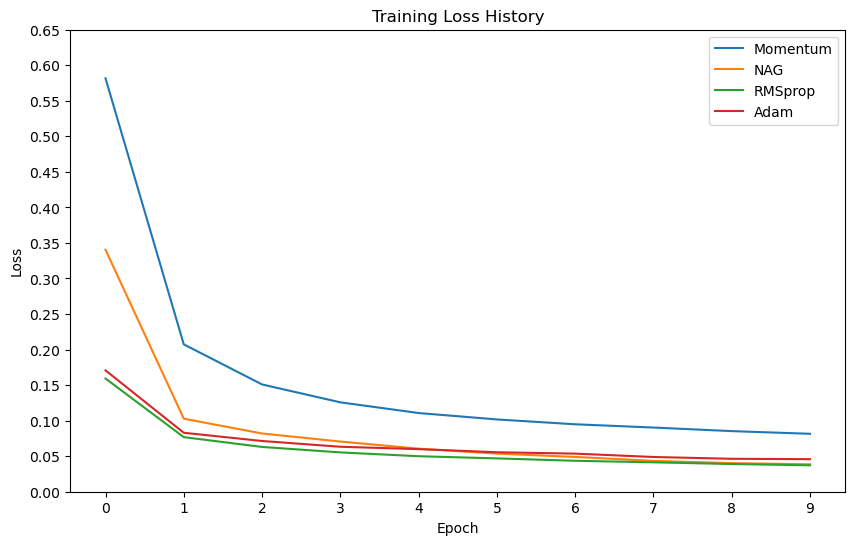

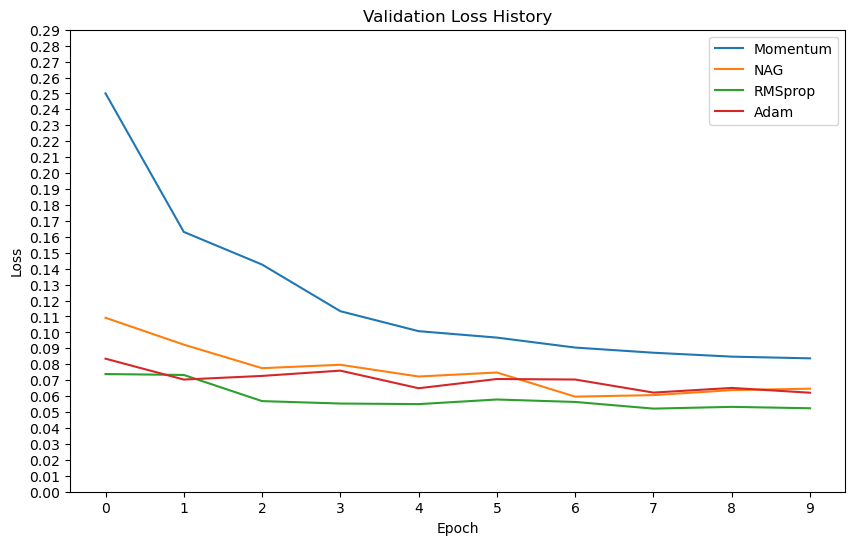

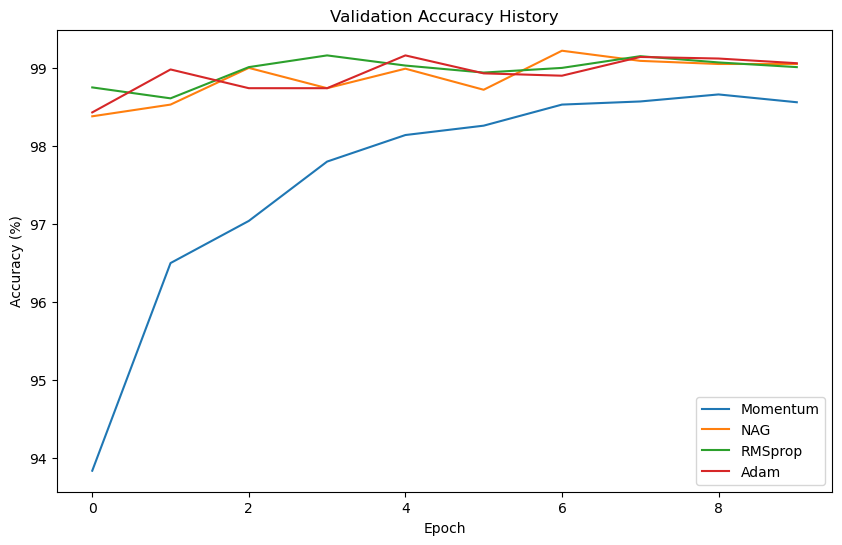

In [41]:
print("\nFinal Validation Accuracies:")

print(f"Momentum Optimizer: {val_acc_momentum[-1]:.2f}%")
print(f"NAG Optimizer: {val_acc_nag[-1]:.2f}%")
print(f"RMSprop Optimizer: {val_acc_rmsprop[-1]:.2f}%")
print(f"Adam Optimizer: {val_acc_adam[-1]:.2f}%")

# Plot training loss history

plt.figure(figsize=(10, 6))
plt.plot(train_loss_momentum, label='Momentum')
plt.plot(train_loss_nag, label='NAG')
plt.plot(train_loss_rmsprop, label='RMSprop')
plt.plot(train_loss_adam, label='Adam')
plt.title('Training Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# x axis from 0 to 10
plt.xticks(np.arange(0, 10, 1))
# y axis from 0 to 0.7    
plt.yticks(np.arange(0, 0.7, 0.05))
plt.legend()
plt.show()


# Plot validation loss history

plt.figure(figsize=(10, 6))
plt.plot(val_loss_momentum, label='Momentum')
plt.plot(val_loss_nag, label='NAG')
plt.plot(val_loss_rmsprop, label='RMSprop')
plt.plot(val_loss_adam, label='Adam')
plt.title('Validation Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# x axis from 0 to 10
plt.xticks(np.arange(0, 10, 1))
# y axis from 0 to 0.2
plt.yticks(np.arange(0, 0.3, 0.01))
plt.legend()
plt.show()


# plot accuracy history

plt.figure(figsize=(10, 6))
plt.plot(val_acc_momentum, label='Momentum')
plt.plot(val_acc_nag, label='NAG')
plt.plot(val_acc_rmsprop, label='RMSprop')
plt.plot(val_acc_adam, label='Adam')
plt.title('Validation Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


# 2.2

In [35]:
batch_sizes = [4, 8, 16, 32]
learning_rates = [0.05, 0.001]

def compare_optimizers(optimizer_class, optimizer_name, batch_sizes, learning_rates, **kwargs):

    results = {}  # a nested dictionary to store the results for each batch size and learning rate
    for batch_size in batch_sizes:
        for learning_rate in learning_rates:
            print(f"\nTraining with {optimizer_name}, Batch Size: {batch_size}, Learning Rate: {learning_rate}")
            # Define DataLoaders
            train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
            test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
            
            # Initialize model and optimizer
            model = CNNModel()
            optimizer = optimizer_class(model.parameters(), lr=learning_rate, **kwargs)
            
            # Train the model
            train_loss, val_loss, val_acc = train_model(
                model, train_loader, test_loader, optimizer, num_epochs=3, l1_lambda=1e-5)
            
            # Store the results
            if batch_size not in results:
                results[batch_size] = {}
            results[batch_size][learning_rate] = {
                'train_loss': train_loss,
                'val_loss': val_loss,
                'val_accuracy': val_acc
            }
            
    return results

In [36]:
# Hyperparameters for Momentum
beta_momentum = 0.9

momentum_results = compare_optimizers(
    optimizer_class=SGD_Momentum,
    optimizer_name="Momentum",
    batch_sizes=batch_sizes,
    learning_rates=learning_rates,
    beta=beta_momentum
)



Training with Momentum, Batch Size: 4, Learning Rate: 0.05


Epoch 1/3:  20%|██        | 3057/15000 [00:11<02:31, 78.82batch/s, loss=0.0509] 

Epoch [1/3], Step [3000/15000], Train Loss: 0.3305, Val Loss: 0.1819, Val Accuracy: 96.01%


Epoch 1/3:  40%|████      | 6053/15000 [00:21<01:21, 109.46batch/s, loss=0.0584]

Epoch [1/3], Step [6000/15000], Train Loss: 0.2427, Val Loss: 0.1282, Val Accuracy: 97.38%


Epoch 1/3:  60%|██████    | 9048/15000 [00:30<00:56, 105.16batch/s, loss=0.0483]

Epoch [1/3], Step [9000/15000], Train Loss: 0.2067, Val Loss: 0.1009, Val Accuracy: 98.16%


Epoch 1/3:  80%|████████  | 12036/15000 [00:39<00:28, 103.14batch/s, loss=0.0458]

Epoch [1/3], Step [12000/15000], Train Loss: 0.1852, Val Loss: 0.0942, Val Accuracy: 98.53%


Epoch 1/3: 100%|██████████| 15000/15000 [00:48<00:00, 311.40batch/s, loss=0.868] 


Epoch [1/3], Step [15000/15000], Train Loss: 0.1723, Val Loss: 0.0951, Val Accuracy: 98.47%


Epoch 2/3:  20%|██        | 3031/15000 [00:10<02:37, 76.09batch/s, loss=0.0455] 

Epoch [2/3], Step [3000/15000], Train Loss: 0.0930, Val Loss: 0.0887, Val Accuracy: 98.59%


Epoch 2/3:  40%|████      | 6036/15000 [00:20<01:40, 89.63batch/s, loss=0.876]  

Epoch [2/3], Step [6000/15000], Train Loss: 0.0954, Val Loss: 0.0877, Val Accuracy: 98.59%


Epoch 2/3:  60%|██████    | 9047/15000 [00:29<00:55, 107.89batch/s, loss=0.0411]

Epoch [2/3], Step [9000/15000], Train Loss: 0.0955, Val Loss: 0.0827, Val Accuracy: 98.51%


Epoch 2/3:  80%|████████  | 12066/15000 [00:38<00:27, 108.29batch/s, loss=0.0396]

Epoch [2/3], Step [12000/15000], Train Loss: 0.0943, Val Loss: 0.0838, Val Accuracy: 98.70%


Epoch 2/3: 100%|██████████| 15000/15000 [00:47<00:00, 317.75batch/s, loss=0.0389]


Epoch [2/3], Step [15000/15000], Train Loss: 0.0927, Val Loss: 0.0757, Val Accuracy: 98.88%


Epoch 3/3:  20%|██        | 3058/15000 [00:09<01:51, 107.58batch/s, loss=0.0489]

Epoch [3/3], Step [3000/15000], Train Loss: 0.0790, Val Loss: 0.0722, Val Accuracy: 98.86%


Epoch 3/3:  40%|████      | 6074/15000 [00:18<01:21, 108.89batch/s, loss=0.069] 

Epoch [3/3], Step [6000/15000], Train Loss: 0.0762, Val Loss: 0.0728, Val Accuracy: 98.84%


Epoch 3/3:  60%|██████    | 9061/15000 [00:26<00:53, 110.48batch/s, loss=0.0386]

Epoch [3/3], Step [9000/15000], Train Loss: 0.0785, Val Loss: 0.0841, Val Accuracy: 98.48%


Epoch 3/3:  80%|████████  | 12066/15000 [00:35<00:26, 108.93batch/s, loss=0.0389]

Epoch [3/3], Step [12000/15000], Train Loss: 0.0779, Val Loss: 0.0829, Val Accuracy: 98.56%


Epoch 3/3: 100%|██████████| 15000/15000 [00:44<00:00, 336.13batch/s, loss=0.0391]


Epoch [3/3], Step [15000/15000], Train Loss: 0.0785, Val Loss: 0.0747, Val Accuracy: 98.74%

Training with Momentum, Batch Size: 4, Learning Rate: 0.001


Epoch 1/3:  20%|██        | 3043/15000 [00:09<01:51, 107.52batch/s, loss=0.247] 

Epoch [1/3], Step [3000/15000], Train Loss: 1.0028, Val Loss: 0.4012, Val Accuracy: 89.76%


Epoch 1/3:  40%|████      | 6059/15000 [00:18<01:20, 111.73batch/s, loss=0.127] 

Epoch [1/3], Step [6000/15000], Train Loss: 0.6812, Val Loss: 0.2913, Val Accuracy: 92.73%


Epoch 1/3:  60%|██████    | 9046/15000 [00:26<00:54, 109.59batch/s, loss=0.142] 

Epoch [1/3], Step [9000/15000], Train Loss: 0.5441, Val Loss: 0.2319, Val Accuracy: 94.45%


Epoch 1/3:  80%|████████  | 12032/15000 [00:35<00:28, 103.06batch/s, loss=0.0744]

Epoch [1/3], Step [12000/15000], Train Loss: 0.4687, Val Loss: 0.2256, Val Accuracy: 94.46%


Epoch 1/3: 100%|██████████| 15000/15000 [00:44<00:00, 336.90batch/s, loss=0.196] 


Epoch [1/3], Step [15000/15000], Train Loss: 0.4160, Val Loss: 0.1654, Val Accuracy: 96.08%


Epoch 2/3:  20%|██        | 3050/15000 [00:09<02:01, 98.76batch/s, loss=0.106]  

Epoch [2/3], Step [3000/15000], Train Loss: 0.1796, Val Loss: 0.1557, Val Accuracy: 96.81%


Epoch 2/3:  40%|████      | 6059/15000 [00:18<01:22, 108.33batch/s, loss=0.272] 

Epoch [2/3], Step [6000/15000], Train Loss: 0.1700, Val Loss: 0.1430, Val Accuracy: 97.04%


Epoch 2/3:  60%|██████    | 9065/15000 [00:27<00:57, 103.13batch/s, loss=0.0633]

Epoch [2/3], Step [9000/15000], Train Loss: 0.1628, Val Loss: 0.1335, Val Accuracy: 97.21%


Epoch 2/3:  81%|████████  | 12083/15000 [00:36<00:27, 106.50batch/s, loss=0.19]  

Epoch [2/3], Step [12000/15000], Train Loss: 0.1589, Val Loss: 0.1274, Val Accuracy: 97.33%


Epoch 2/3: 100%|██████████| 15000/15000 [00:45<00:00, 332.29batch/s, loss=0.0509]


Epoch [2/3], Step [15000/15000], Train Loss: 0.1554, Val Loss: 0.1215, Val Accuracy: 97.47%


Epoch 3/3:  20%|██        | 3032/15000 [00:09<01:58, 101.37batch/s, loss=0.0582]

Epoch [3/3], Step [3000/15000], Train Loss: 0.1226, Val Loss: 0.1133, Val Accuracy: 97.58%


Epoch 3/3:  40%|████      | 6051/15000 [00:18<01:23, 107.41batch/s, loss=0.0631]

Epoch [3/3], Step [6000/15000], Train Loss: 0.1249, Val Loss: 0.1164, Val Accuracy: 97.65%


Epoch 3/3:  60%|██████    | 9031/15000 [00:26<01:12, 81.95batch/s, loss=0.275]  

Epoch [3/3], Step [9000/15000], Train Loss: 0.1233, Val Loss: 0.1047, Val Accuracy: 97.98%


Epoch 3/3:  80%|████████  | 12056/15000 [00:35<00:28, 101.68batch/s, loss=0.0495]

Epoch [3/3], Step [12000/15000], Train Loss: 0.1236, Val Loss: 0.1012, Val Accuracy: 98.12%


Epoch 3/3: 100%|██████████| 15000/15000 [00:44<00:00, 336.36batch/s, loss=0.254] 


Epoch [3/3], Step [15000/15000], Train Loss: 0.1220, Val Loss: 0.1108, Val Accuracy: 97.84%

Training with Momentum, Batch Size: 8, Learning Rate: 0.05


Epoch 1/3:  21%|██        | 1542/7500 [00:05<00:54, 108.52batch/s, loss=0.118] 

Epoch [1/3], Step [1500/7500], Train Loss: 0.3331, Val Loss: 0.1623, Val Accuracy: 96.34%


Epoch 1/3:  41%|████      | 3038/7500 [00:11<00:42, 105.33batch/s, loss=0.0487]

Epoch [1/3], Step [3000/7500], Train Loss: 0.2373, Val Loss: 0.1063, Val Accuracy: 97.95%


Epoch 1/3:  60%|██████    | 4529/7500 [00:16<00:29, 99.34batch/s, loss=0.0481] 

Epoch [1/3], Step [4500/7500], Train Loss: 0.1968, Val Loss: 0.0991, Val Accuracy: 98.39%


Epoch 1/3:  81%|████████  | 6049/7500 [00:22<00:13, 108.69batch/s, loss=0.333] 

Epoch [1/3], Step [6000/7500], Train Loss: 0.1777, Val Loss: 0.0894, Val Accuracy: 98.64%


Epoch 1/3: 100%|██████████| 7500/7500 [00:28<00:00, 267.39batch/s, loss=0.0489]


Epoch [1/3], Step [7500/7500], Train Loss: 0.1638, Val Loss: 0.0856, Val Accuracy: 98.73%


Epoch 2/3:  21%|██        | 1562/7500 [00:05<00:55, 106.44batch/s, loss=0.056] 

Epoch [2/3], Step [1500/7500], Train Loss: 0.0839, Val Loss: 0.0843, Val Accuracy: 98.76%


Epoch 2/3:  41%|████      | 3053/7500 [00:11<00:41, 107.46batch/s, loss=0.0466]

Epoch [2/3], Step [3000/7500], Train Loss: 0.0873, Val Loss: 0.0876, Val Accuracy: 98.51%


Epoch 2/3:  61%|██████    | 4543/7500 [00:17<00:27, 108.74batch/s, loss=0.0432]

Epoch [2/3], Step [4500/7500], Train Loss: 0.0857, Val Loss: 0.0774, Val Accuracy: 98.80%


Epoch 2/3:  81%|████████  | 6064/7500 [00:22<00:13, 107.78batch/s, loss=0.0439]

Epoch [2/3], Step [6000/7500], Train Loss: 0.0847, Val Loss: 0.0860, Val Accuracy: 98.56%


Epoch 2/3: 100%|██████████| 7500/7500 [00:28<00:00, 267.22batch/s, loss=0.104] 


Epoch [2/3], Step [7500/7500], Train Loss: 0.0843, Val Loss: 0.0758, Val Accuracy: 98.90%


Epoch 3/3:  21%|██        | 1570/7500 [00:05<00:54, 109.31batch/s, loss=0.0404]

Epoch [3/3], Step [1500/7500], Train Loss: 0.0644, Val Loss: 0.0886, Val Accuracy: 98.66%


Epoch 3/3:  41%|████      | 3067/7500 [00:11<00:40, 109.03batch/s, loss=0.0391]

Epoch [3/3], Step [3000/7500], Train Loss: 0.0675, Val Loss: 0.0630, Val Accuracy: 99.21%


Epoch 3/3:  61%|██████    | 4563/7500 [00:16<00:26, 108.95batch/s, loss=0.0412]

Epoch [3/3], Step [4500/7500], Train Loss: 0.0697, Val Loss: 0.0653, Val Accuracy: 99.06%


Epoch 3/3:  81%|████████  | 6060/7500 [00:22<00:13, 109.00batch/s, loss=0.0388]

Epoch [3/3], Step [6000/7500], Train Loss: 0.0689, Val Loss: 0.0939, Val Accuracy: 98.25%


Epoch 3/3: 100%|██████████| 7500/7500 [00:27<00:00, 268.36batch/s, loss=0.0435]


Epoch [3/3], Step [7500/7500], Train Loss: 0.0690, Val Loss: 0.0742, Val Accuracy: 98.95%

Training with Momentum, Batch Size: 8, Learning Rate: 0.001


Epoch 1/3:  21%|██        | 1538/7500 [00:05<00:59, 100.04batch/s, loss=0.495]

Epoch [1/3], Step [1500/7500], Train Loss: 1.6956, Val Loss: 0.7066, Val Accuracy: 83.68%


Epoch 1/3:  41%|████      | 3055/7500 [00:11<00:41, 106.06batch/s, loss=0.568] 

Epoch [1/3], Step [3000/7500], Train Loss: 1.1068, Val Loss: 0.3835, Val Accuracy: 90.43%


Epoch 1/3:  60%|██████    | 4535/7500 [00:17<00:28, 102.51batch/s, loss=0.0884]

Epoch [1/3], Step [4500/7500], Train Loss: 0.8563, Val Loss: 0.3127, Val Accuracy: 92.51%


Epoch 1/3:  81%|████████  | 6046/7500 [00:22<00:13, 109.30batch/s, loss=0.109] 

Epoch [1/3], Step [6000/7500], Train Loss: 0.7176, Val Loss: 0.2710, Val Accuracy: 93.20%


Epoch 1/3: 100%|██████████| 7500/7500 [00:28<00:00, 265.99batch/s, loss=0.39]  


Epoch [1/3], Step [7500/7500], Train Loss: 0.6283, Val Loss: 0.2491, Val Accuracy: 93.86%


Epoch 2/3:  21%|██        | 1565/7500 [00:05<00:55, 106.07batch/s, loss=0.0951]

Epoch [2/3], Step [1500/7500], Train Loss: 0.2420, Val Loss: 0.2167, Val Accuracy: 95.11%


Epoch 2/3:  41%|████      | 3042/7500 [00:11<00:41, 106.83batch/s, loss=0.143] 

Epoch [2/3], Step [3000/7500], Train Loss: 0.2309, Val Loss: 0.1981, Val Accuracy: 95.40%


Epoch 2/3:  60%|██████    | 4528/7500 [00:17<00:29, 100.36batch/s, loss=0.278] 

Epoch [2/3], Step [4500/7500], Train Loss: 0.2217, Val Loss: 0.1876, Val Accuracy: 95.81%


Epoch 2/3:  81%|████████  | 6054/7500 [00:22<00:14, 100.80batch/s, loss=0.111] 

Epoch [2/3], Step [6000/7500], Train Loss: 0.2137, Val Loss: 0.1721, Val Accuracy: 96.28%


Epoch 2/3: 100%|██████████| 7500/7500 [00:28<00:00, 267.72batch/s, loss=0.0511]


Epoch [2/3], Step [7500/7500], Train Loss: 0.2070, Val Loss: 0.1647, Val Accuracy: 96.38%


Epoch 3/3:  21%|██        | 1551/7500 [00:05<00:53, 110.45batch/s, loss=0.162] 

Epoch [3/3], Step [1500/7500], Train Loss: 0.1716, Val Loss: 0.1508, Val Accuracy: 96.84%


Epoch 3/3:  41%|████      | 3052/7500 [00:11<00:40, 108.50batch/s, loss=0.0636]

Epoch [3/3], Step [3000/7500], Train Loss: 0.1652, Val Loss: 0.1488, Val Accuracy: 96.98%


Epoch 3/3:  60%|██████    | 4536/7500 [00:17<00:28, 104.37batch/s, loss=0.0553]

Epoch [3/3], Step [4500/7500], Train Loss: 0.1624, Val Loss: 0.1385, Val Accuracy: 97.10%


Epoch 3/3:  81%|████████  | 6055/7500 [00:22<00:13, 108.56batch/s, loss=0.0461]

Epoch [3/3], Step [6000/7500], Train Loss: 0.1572, Val Loss: 0.1363, Val Accuracy: 97.10%


Epoch 3/3: 100%|██████████| 7500/7500 [00:28<00:00, 264.44batch/s, loss=0.0576]


Epoch [3/3], Step [7500/7500], Train Loss: 0.1533, Val Loss: 0.1295, Val Accuracy: 97.44%

Training with Momentum, Batch Size: 16, Learning Rate: 0.05


Epoch 1/3:  21%|██        | 770/3750 [00:06<01:07, 44.02batch/s, loss=0.184]  

Epoch [1/3], Step [750/3750], Train Loss: 0.3865, Val Loss: 0.1452, Val Accuracy: 96.72%


Epoch 1/3:  41%|████      | 1521/3750 [00:12<00:50, 44.28batch/s, loss=0.126]  

Epoch [1/3], Step [1500/3750], Train Loss: 0.2675, Val Loss: 0.1230, Val Accuracy: 97.50%


Epoch 1/3:  61%|██████    | 2269/3750 [00:18<00:34, 43.45batch/s, loss=0.0904] 

Epoch [1/3], Step [2250/3750], Train Loss: 0.2208, Val Loss: 0.1210, Val Accuracy: 97.48%


Epoch 1/3:  81%|████████  | 3029/3750 [00:24<00:16, 42.42batch/s, loss=0.0506] 

Epoch [1/3], Step [3000/3750], Train Loss: 0.1931, Val Loss: 0.1081, Val Accuracy: 98.04%


Epoch 1/3: 100%|██████████| 3750/3750 [00:30<00:00, 124.73batch/s, loss=0.371] 


Epoch [1/3], Step [3750/3750], Train Loss: 0.1751, Val Loss: 0.1034, Val Accuracy: 98.08%


Epoch 2/3:  20%|██        | 766/3750 [00:06<01:29, 33.28batch/s, loss=0.053]  

Epoch [2/3], Step [750/3750], Train Loss: 0.0882, Val Loss: 0.0844, Val Accuracy: 98.57%


Epoch 2/3:  40%|████      | 1514/3750 [00:12<01:08, 32.74batch/s, loss=0.14]   

Epoch [2/3], Step [1500/3750], Train Loss: 0.0862, Val Loss: 0.0856, Val Accuracy: 98.50%


Epoch 2/3:  61%|██████    | 2276/3750 [00:18<00:35, 41.06batch/s, loss=0.0546] 

Epoch [2/3], Step [2250/3750], Train Loss: 0.0846, Val Loss: 0.0863, Val Accuracy: 98.69%


Epoch 2/3:  81%|████████  | 3022/3750 [00:24<00:18, 40.09batch/s, loss=0.0546] 

Epoch [2/3], Step [3000/3750], Train Loss: 0.0833, Val Loss: 0.0741, Val Accuracy: 98.94%


Epoch 2/3: 100%|██████████| 3750/3750 [00:30<00:00, 123.93batch/s, loss=0.0475]


Epoch [2/3], Step [3750/3750], Train Loss: 0.0844, Val Loss: 0.0735, Val Accuracy: 98.90%


Epoch 3/3:  20%|██        | 767/3750 [00:06<01:08, 43.59batch/s, loss=0.041]  

Epoch [3/3], Step [750/3750], Train Loss: 0.0707, Val Loss: 0.0727, Val Accuracy: 98.86%


Epoch 3/3:  41%|████      | 1519/3750 [00:12<00:50, 43.79batch/s, loss=0.0625] 

Epoch [3/3], Step [1500/3750], Train Loss: 0.0697, Val Loss: 0.0753, Val Accuracy: 98.90%


Epoch 3/3:  61%|██████    | 2276/3750 [00:18<00:36, 40.37batch/s, loss=0.04]   

Epoch [3/3], Step [2250/3750], Train Loss: 0.0696, Val Loss: 0.0681, Val Accuracy: 99.05%


Epoch 3/3:  80%|████████  | 3017/3750 [00:24<00:17, 42.70batch/s, loss=0.0448] 

Epoch [3/3], Step [3000/3750], Train Loss: 0.0682, Val Loss: 0.0679, Val Accuracy: 99.13%


Epoch 3/3: 100%|██████████| 3750/3750 [00:30<00:00, 123.51batch/s, loss=0.0389]


Epoch [3/3], Step [3750/3750], Train Loss: 0.0683, Val Loss: 0.0671, Val Accuracy: 98.99%

Training with Momentum, Batch Size: 16, Learning Rate: 0.001


Epoch 1/3:  21%|██        | 773/3750 [00:06<01:09, 43.05batch/s, loss=1.43]  

Epoch [1/3], Step [750/3750], Train Loss: 1.9510, Val Loss: 1.2933, Val Accuracy: 77.37%


Epoch 1/3:  40%|████      | 1518/3750 [00:12<00:53, 41.83batch/s, loss=0.444] 

Epoch [1/3], Step [1500/3750], Train Loss: 1.3884, Val Loss: 0.5507, Val Accuracy: 87.41%


Epoch 1/3:  61%|██████    | 2272/3750 [00:18<00:34, 42.47batch/s, loss=0.416] 

Epoch [1/3], Step [2250/3750], Train Loss: 1.0899, Val Loss: 0.4168, Val Accuracy: 89.90%


Epoch 1/3:  81%|████████  | 3020/3750 [00:24<00:16, 43.20batch/s, loss=0.277] 

Epoch [1/3], Step [3000/3750], Train Loss: 0.9226, Val Loss: 0.3684, Val Accuracy: 90.84%


Epoch 1/3: 100%|██████████| 3750/3750 [00:30<00:00, 121.26batch/s, loss=0.197] 


Epoch [1/3], Step [3750/3750], Train Loss: 0.8124, Val Loss: 0.3304, Val Accuracy: 91.93%


Epoch 2/3:  21%|██        | 776/3750 [00:06<01:10, 42.34batch/s, loss=0.122]  

Epoch [2/3], Step [750/3750], Train Loss: 0.3379, Val Loss: 0.3047, Val Accuracy: 92.47%


Epoch 2/3:  40%|████      | 1517/3750 [00:12<00:52, 42.58batch/s, loss=0.292]  

Epoch [2/3], Step [1500/3750], Train Loss: 0.3265, Val Loss: 0.2862, Val Accuracy: 93.13%


Epoch 2/3:  61%|██████    | 2272/3750 [00:18<00:34, 42.98batch/s, loss=0.245]  

Epoch [2/3], Step [2250/3750], Train Loss: 0.3152, Val Loss: 0.2695, Val Accuracy: 93.62%


Epoch 2/3:  81%|████████  | 3028/3750 [00:24<00:16, 42.80batch/s, loss=0.198]  

Epoch [2/3], Step [3000/3750], Train Loss: 0.3053, Val Loss: 0.2597, Val Accuracy: 94.07%


Epoch 2/3: 100%|██████████| 3750/3750 [00:30<00:00, 121.83batch/s, loss=0.0696]


Epoch [2/3], Step [3750/3750], Train Loss: 0.2961, Val Loss: 0.2362, Val Accuracy: 94.25%


Epoch 3/3:  20%|██        | 767/3750 [00:06<01:11, 41.88batch/s, loss=0.227]  

Epoch [3/3], Step [750/3750], Train Loss: 0.2493, Val Loss: 0.2309, Val Accuracy: 94.67%


Epoch 3/3:  41%|████      | 1519/3750 [00:12<00:54, 40.78batch/s, loss=0.702]  

Epoch [3/3], Step [1500/3750], Train Loss: 0.2429, Val Loss: 0.2153, Val Accuracy: 95.14%


Epoch 3/3:  61%|██████    | 2271/3750 [00:18<00:36, 40.02batch/s, loss=0.0911] 

Epoch [3/3], Step [2250/3750], Train Loss: 0.2380, Val Loss: 0.2048, Val Accuracy: 95.12%


Epoch 3/3:  81%|████████  | 3024/3750 [00:24<00:16, 42.79batch/s, loss=0.193]  

Epoch [3/3], Step [3000/3750], Train Loss: 0.2324, Val Loss: 0.1960, Val Accuracy: 95.65%


Epoch 3/3: 100%|██████████| 3750/3750 [00:30<00:00, 121.91batch/s, loss=0.209] 


Epoch [3/3], Step [3750/3750], Train Loss: 0.2268, Val Loss: 0.1919, Val Accuracy: 95.80%

Training with Momentum, Batch Size: 32, Learning Rate: 0.05


Epoch 1/3:  21%|██        | 385/1875 [00:05<01:00, 24.63batch/s, loss=0.0725] 

Epoch [1/3], Step [375/1875], Train Loss: 0.5382, Val Loss: 0.1809, Val Accuracy: 96.04%


Epoch 1/3:  41%|████      | 768/1875 [00:09<00:35, 31.60batch/s, loss=0.0566] 

Epoch [1/3], Step [750/1875], Train Loss: 0.3538, Val Loss: 0.1296, Val Accuracy: 97.26%


Epoch 1/3:  61%|██████    | 1142/1875 [00:14<00:23, 31.70batch/s, loss=0.188]  

Epoch [1/3], Step [1125/1875], Train Loss: 0.2809, Val Loss: 0.1196, Val Accuracy: 97.43%


Epoch 1/3:  81%|████████  | 1515/1875 [00:19<00:11, 31.23batch/s, loss=0.0527] 

Epoch [1/3], Step [1500/1875], Train Loss: 0.2400, Val Loss: 0.1066, Val Accuracy: 98.02%


Epoch 1/3: 100%|██████████| 1875/1875 [00:24<00:00, 77.61batch/s, loss=0.314]  


Epoch [1/3], Step [1875/1875], Train Loss: 0.2142, Val Loss: 0.1044, Val Accuracy: 98.04%


Epoch 2/3:  21%|██        | 393/1875 [00:05<00:48, 30.49batch/s, loss=0.0477] 

Epoch [2/3], Step [375/1875], Train Loss: 0.0992, Val Loss: 0.0961, Val Accuracy: 98.29%


Epoch 2/3:  41%|████      | 761/1875 [00:10<00:34, 31.90batch/s, loss=0.0804] 

Epoch [2/3], Step [750/1875], Train Loss: 0.0996, Val Loss: 0.0898, Val Accuracy: 98.62%


Epoch 2/3:  61%|██████    | 1142/1875 [00:15<00:22, 31.89batch/s, loss=0.0514] 

Epoch [2/3], Step [1125/1875], Train Loss: 0.0958, Val Loss: 0.0994, Val Accuracy: 98.24%


Epoch 2/3:  81%|████████  | 1514/1875 [00:19<00:11, 31.60batch/s, loss=0.0506] 

Epoch [2/3], Step [1500/1875], Train Loss: 0.0940, Val Loss: 0.0932, Val Accuracy: 98.43%


Epoch 2/3: 100%|██████████| 1875/1875 [00:24<00:00, 76.37batch/s, loss=0.0495] 


Epoch [2/3], Step [1875/1875], Train Loss: 0.0920, Val Loss: 0.0917, Val Accuracy: 98.51%


Epoch 3/3:  21%|██        | 393/1875 [00:05<00:46, 31.88batch/s, loss=0.211]  

Epoch [3/3], Step [375/1875], Train Loss: 0.0760, Val Loss: 0.0795, Val Accuracy: 98.76%


Epoch 3/3:  41%|████      | 762/1875 [00:10<00:34, 32.70batch/s, loss=0.0708] 

Epoch [3/3], Step [750/1875], Train Loss: 0.0757, Val Loss: 0.0872, Val Accuracy: 98.48%


Epoch 3/3:  61%|██████    | 1137/1875 [01:42<00:58, 12.59batch/s, loss=0.0687] 

Epoch [3/3], Step [1125/1875], Train Loss: 0.0764, Val Loss: 0.0771, Val Accuracy: 98.87%


Epoch 3/3:  81%|████████  | 1511/1875 [01:47<00:11, 32.11batch/s, loss=0.0436] 

Epoch [3/3], Step [1500/1875], Train Loss: 0.0763, Val Loss: 0.0719, Val Accuracy: 98.93%


Epoch 3/3: 100%|██████████| 1875/1875 [01:52<00:00, 16.72batch/s, loss=0.508]  


Epoch [3/3], Step [1875/1875], Train Loss: 0.0767, Val Loss: 0.0796, Val Accuracy: 98.79%

Training with Momentum, Batch Size: 32, Learning Rate: 0.001


Epoch 1/3:  21%|██        | 395/1875 [00:04<00:47, 31.08batch/s, loss=2.09] 

Epoch [1/3], Step [375/1875], Train Loss: 2.2608, Val Loss: 2.1535, Val Accuracy: 62.37%


Epoch 1/3:  41%|████      | 769/1875 [00:09<00:34, 32.14batch/s, loss=1.67] 

Epoch [1/3], Step [750/1875], Train Loss: 2.1010, Val Loss: 1.6493, Val Accuracy: 70.20%


Epoch 1/3:  61%|██████    | 1142/1875 [00:14<00:23, 31.01batch/s, loss=0.908] 

Epoch [1/3], Step [1125/1875], Train Loss: 1.8267, Val Loss: 0.9215, Val Accuracy: 82.43%


Epoch 1/3:  81%|████████  | 1512/1875 [00:19<00:12, 30.25batch/s, loss=0.817] 

Epoch [1/3], Step [1500/1875], Train Loss: 1.5615, Val Loss: 0.6161, Val Accuracy: 86.32%


Epoch 1/3: 100%|██████████| 1875/1875 [00:24<00:00, 77.12batch/s, loss=0.422] 


Epoch [1/3], Step [1875/1875], Train Loss: 1.3626, Val Loss: 0.5000, Val Accuracy: 87.86%


Epoch 2/3:  21%|██        | 391/1875 [00:05<00:49, 29.76batch/s, loss=0.287] 

Epoch [2/3], Step [375/1875], Train Loss: 0.4799, Val Loss: 0.4364, Val Accuracy: 89.26%


Epoch 2/3:  41%|████      | 767/1875 [00:10<00:39, 28.23batch/s, loss=0.343] 

Epoch [2/3], Step [750/1875], Train Loss: 0.4549, Val Loss: 0.3969, Val Accuracy: 90.46%


Epoch 2/3:  61%|██████    | 1137/1875 [00:43<00:23, 31.94batch/s, loss=0.372] 

Epoch [2/3], Step [1125/1875], Train Loss: 0.4305, Val Loss: 0.3691, Val Accuracy: 90.74%


Epoch 2/3:  80%|████████  | 1505/1875 [00:58<02:27,  2.51batch/s, loss=0.325]

Epoch [2/3], Step [1500/1875], Train Loss: 0.4213, Val Loss: 0.3483, Val Accuracy: 91.41%


Epoch 2/3: 100%|██████████| 1875/1875 [01:19<00:00, 23.66batch/s, loss=0.204]


Epoch [2/3], Step [1875/1875], Train Loss: 0.4088, Val Loss: 0.3320, Val Accuracy: 91.59%


Epoch 3/3:  21%|██        | 391/1875 [07:28<00:52, 28.45batch/s, loss=0.222]   

Epoch [3/3], Step [375/1875], Train Loss: 0.3315, Val Loss: 0.3146, Val Accuracy: 92.37%


Epoch 3/3:  41%|████      | 768/1875 [07:32<00:32, 33.82batch/s, loss=0.499] 

Epoch [3/3], Step [750/1875], Train Loss: 0.3242, Val Loss: 0.3085, Val Accuracy: 92.49%


Epoch 3/3:  61%|██████    | 1140/1875 [07:37<00:22, 33.26batch/s, loss=0.366] 

Epoch [3/3], Step [1125/1875], Train Loss: 0.3222, Val Loss: 0.2934, Val Accuracy: 92.85%


Epoch 3/3:  81%|████████  | 1512/1875 [07:42<00:11, 32.09batch/s, loss=0.115]  

Epoch [3/3], Step [1500/1875], Train Loss: 0.3175, Val Loss: 0.2811, Val Accuracy: 93.18%


Epoch 3/3: 100%|██████████| 1875/1875 [07:46<00:00,  4.02batch/s, loss=0.228] 

Epoch [3/3], Step [1875/1875], Train Loss: 0.3138, Val Loss: 0.2690, Val Accuracy: 93.59%


In [37]:
# Hyperparameters for NAG
beta_nag = 0.95

nag_results = compare_optimizers(
    optimizer_class=NAG,
    optimizer_name="Nesterov's Accelerated Gradient",
    batch_sizes=batch_sizes,
    learning_rates=learning_rates,
    beta=beta_nag
)



Training with Nesterov's Accelerated Gradient, Batch Size: 4, Learning Rate: 0.05


Epoch 1/3:  20%|██        | 3044/15000 [00:09<01:46, 112.40batch/s, loss=2.26]

Epoch [1/3], Step [3000/15000], Train Loss: 2.4122, Val Loss: 2.3539, Val Accuracy: 11.35%


Epoch 1/3:  40%|████      | 6031/15000 [00:18<01:47, 83.12batch/s, loss=2.64] 

Epoch [1/3], Step [6000/15000], Train Loss: 2.3964, Val Loss: 2.3540, Val Accuracy: 11.35%


Epoch 1/3:  60%|██████    | 9066/15000 [02:02<00:56, 105.53batch/s, loss=2.41] 

Epoch [1/3], Step [9000/15000], Train Loss: 2.3909, Val Loss: 2.3696, Val Accuracy: 10.28%


Epoch 1/3:  80%|████████  | 12055/15000 [02:12<00:27, 108.97batch/s, loss=2.53]

Epoch [1/3], Step [12000/15000], Train Loss: 2.3886, Val Loss: 2.3437, Val Accuracy: 8.92%


Epoch 1/3: 100%|██████████| 15000/15000 [02:21<00:00, 106.23batch/s, loss=2.14]


Epoch [1/3], Step [15000/15000], Train Loss: 2.3856, Val Loss: 2.3934, Val Accuracy: 10.32%


Epoch 2/3:  20%|██        | 3070/15000 [00:09<01:51, 106.75batch/s, loss=2.16]

Epoch [2/3], Step [3000/15000], Train Loss: 2.3741, Val Loss: 2.4056, Val Accuracy: 9.80%


Epoch 2/3:  40%|████      | 6035/15000 [00:18<01:26, 103.35batch/s, loss=2.41]

Epoch [2/3], Step [6000/15000], Train Loss: 2.3744, Val Loss: 2.3782, Val Accuracy: 9.80%


Epoch 2/3:  61%|██████    | 9081/15000 [00:29<00:53, 111.10batch/s, loss=2.19]

Epoch [2/3], Step [9000/15000], Train Loss: 2.3737, Val Loss: 2.3864, Val Accuracy: 9.58%


Epoch 2/3:  80%|████████  | 12050/15000 [00:38<00:28, 105.12batch/s, loss=2.2] 

Epoch [2/3], Step [12000/15000], Train Loss: 2.3732, Val Loss: 2.3793, Val Accuracy: 8.92%


Epoch 2/3: 100%|██████████| 15000/15000 [00:47<00:00, 314.45batch/s, loss=2.3] 


Epoch [2/3], Step [15000/15000], Train Loss: 2.3732, Val Loss: 2.4036, Val Accuracy: 9.58%


Epoch 3/3:  20%|██        | 3041/15000 [00:09<01:49, 108.86batch/s, loss=2.55]

Epoch [3/3], Step [3000/15000], Train Loss: 2.3712, Val Loss: 2.3572, Val Accuracy: 10.09%


Epoch 3/3:  40%|████      | 6054/15000 [00:18<01:26, 103.88batch/s, loss=2.28]

Epoch [3/3], Step [6000/15000], Train Loss: 2.3733, Val Loss: 2.3980, Val Accuracy: 10.28%


Epoch 3/3:  61%|██████    | 9076/15000 [00:47<00:55, 107.31batch/s, loss=2.21]

Epoch [3/3], Step [9000/15000], Train Loss: 2.3713, Val Loss: 2.3352, Val Accuracy: 11.35%


Epoch 3/3:  80%|████████  | 12075/15000 [00:56<00:27, 106.10batch/s, loss=2.77]

Epoch [3/3], Step [12000/15000], Train Loss: 2.3700, Val Loss: 2.3711, Val Accuracy: 10.32%


Epoch 3/3: 100%|██████████| 15000/15000 [01:06<00:00, 226.54batch/s, loss=2.69]


Epoch [3/3], Step [15000/15000], Train Loss: 2.3712, Val Loss: 2.4344, Val Accuracy: 9.82%

Training with Nesterov's Accelerated Gradient, Batch Size: 4, Learning Rate: 0.001


Epoch 1/3:  20%|██        | 3067/15000 [00:09<01:57, 101.40batch/s, loss=0.0485]

Epoch [1/3], Step [3000/15000], Train Loss: 0.3523, Val Loss: 0.1443, Val Accuracy: 96.86%


Epoch 1/3:  40%|████      | 6049/15000 [00:19<01:28, 100.66batch/s, loss=0.0484]

Epoch [1/3], Step [6000/15000], Train Loss: 0.2495, Val Loss: 0.1426, Val Accuracy: 97.01%


Epoch 1/3:  60%|██████    | 9038/15000 [00:29<01:04, 92.63batch/s, loss=0.246]  

Epoch [1/3], Step [9000/15000], Train Loss: 0.2057, Val Loss: 0.0928, Val Accuracy: 98.51%


Epoch 1/3:  80%|████████  | 12030/15000 [00:38<00:33, 88.62batch/s, loss=0.0464] 

Epoch [1/3], Step [12000/15000], Train Loss: 0.1821, Val Loss: 0.0920, Val Accuracy: 98.49%


Epoch 1/3: 100%|██████████| 15000/15000 [00:48<00:00, 308.71batch/s, loss=0.0447]


Epoch [1/3], Step [15000/15000], Train Loss: 0.1654, Val Loss: 0.0885, Val Accuracy: 98.63%


Epoch 2/3:  20%|██        | 3060/15000 [00:10<02:08, 92.60batch/s, loss=0.0437] 

Epoch [2/3], Step [3000/15000], Train Loss: 0.0864, Val Loss: 0.0833, Val Accuracy: 98.66%


Epoch 2/3:  40%|████      | 6045/15000 [00:20<01:38, 90.69batch/s, loss=0.0544] 

Epoch [2/3], Step [6000/15000], Train Loss: 0.0874, Val Loss: 0.0829, Val Accuracy: 98.67%


Epoch 2/3:  60%|██████    | 9062/15000 [00:30<01:14, 79.41batch/s, loss=0.0423] 

Epoch [2/3], Step [9000/15000], Train Loss: 0.0870, Val Loss: 0.0811, Val Accuracy: 98.79%


Epoch 2/3:  80%|████████  | 12010/15000 [00:59<07:02,  7.08batch/s, loss=0.0407] 

Epoch [2/3], Step [12000/15000], Train Loss: 0.0851, Val Loss: 0.0788, Val Accuracy: 98.68%


Epoch 2/3: 100%|██████████| 15000/15000 [01:38<00:00, 153.01batch/s, loss=0.123] 


Epoch [2/3], Step [15000/15000], Train Loss: 0.0837, Val Loss: 0.0694, Val Accuracy: 98.97%


Epoch 3/3:  20%|██        | 3016/15000 [00:38<27:41,  7.21batch/s, loss=0.0399] 

Epoch [3/3], Step [3000/15000], Train Loss: 0.0682, Val Loss: 0.0849, Val Accuracy: 98.55%


Epoch 3/3:  40%|████      | 6073/15000 [01:05<01:36, 92.87batch/s, loss=0.0383] 

Epoch [3/3], Step [6000/15000], Train Loss: 0.0671, Val Loss: 0.0733, Val Accuracy: 98.83%


Epoch 3/3:  60%|██████    | 9060/15000 [01:14<01:00, 97.93batch/s, loss=0.117]  

Epoch [3/3], Step [9000/15000], Train Loss: 0.0674, Val Loss: 0.0652, Val Accuracy: 99.04%


Epoch 3/3:  80%|████████  | 12051/15000 [01:24<00:31, 93.76batch/s, loss=0.0552] 

Epoch [3/3], Step [12000/15000], Train Loss: 0.0669, Val Loss: 0.0670, Val Accuracy: 98.97%


Epoch 3/3: 100%|██████████| 15000/15000 [01:33<00:00, 159.70batch/s, loss=0.0357]


Epoch [3/3], Step [15000/15000], Train Loss: 0.0673, Val Loss: 0.0705, Val Accuracy: 98.88%

Training with Nesterov's Accelerated Gradient, Batch Size: 8, Learning Rate: 0.05


Epoch 1/3:  21%|██        | 1548/7500 [00:06<01:06, 89.57batch/s, loss=2.35] 

Epoch [1/3], Step [1500/7500], Train Loss: 2.5026, Val Loss: 2.4669, Val Accuracy: 9.82%


Epoch 1/3:  41%|████      | 3058/7500 [00:12<00:46, 95.75batch/s, loss=2.35] 

Epoch [1/3], Step [3000/7500], Train Loss: 2.4790, Val Loss: 2.4271, Val Accuracy: 10.28%


Epoch 1/3:  60%|██████    | 4533/7500 [00:18<00:31, 92.86batch/s, loss=2.45] 

Epoch [1/3], Step [4500/7500], Train Loss: 2.4695, Val Loss: 2.4629, Val Accuracy: 10.09%


Epoch 1/3:  81%|████████  | 6038/7500 [00:24<00:15, 91.54batch/s, loss=2.58] 

Epoch [1/3], Step [6000/7500], Train Loss: 2.4616, Val Loss: 2.4358, Val Accuracy: 9.82%


Epoch 1/3: 100%|██████████| 7500/7500 [00:30<00:00, 242.94batch/s, loss=2.59]


Epoch [1/3], Step [7500/7500], Train Loss: 2.4558, Val Loss: 2.4286, Val Accuracy: 9.80%


Epoch 2/3:  20%|██        | 1509/7500 [00:22<13:22,  7.47batch/s, loss=2.45]

Epoch [2/3], Step [1500/7500], Train Loss: 2.4287, Val Loss: 2.4191, Val Accuracy: 10.28%


Epoch 2/3:  40%|████      | 3014/7500 [00:46<09:54,  7.55batch/s, loss=2.43]

Epoch [2/3], Step [3000/7500], Train Loss: 2.4276, Val Loss: 2.4124, Val Accuracy: 10.28%


Epoch 2/3:  60%|██████    | 4512/7500 [01:11<06:44,  7.39batch/s, loss=2.39]

Epoch [2/3], Step [4500/7500], Train Loss: 2.4255, Val Loss: 2.4135, Val Accuracy: 10.10%


Epoch 2/3:  80%|████████  | 6008/7500 [01:36<04:32,  5.47batch/s, loss=2.55]

Epoch [2/3], Step [6000/7500], Train Loss: 2.4246, Val Loss: 2.4418, Val Accuracy: 10.28%


Epoch 2/3: 100%|██████████| 7500/7500 [02:01<00:00, 61.98batch/s, loss=2.38]


Epoch [2/3], Step [7500/7500], Train Loss: 2.4239, Val Loss: 2.4101, Val Accuracy: 10.28%


Epoch 3/3:  20%|██        | 1532/7500 [00:15<01:12, 82.74batch/s, loss=2.43] 

Epoch [3/3], Step [1500/7500], Train Loss: 2.4184, Val Loss: 2.4029, Val Accuracy: 9.82%


Epoch 3/3:  40%|████      | 3021/7500 [00:22<00:59, 75.78batch/s, loss=2.33] 

Epoch [3/3], Step [3000/7500], Train Loss: 2.4162, Val Loss: 2.4393, Val Accuracy: 10.09%


Epoch 3/3:  60%|██████    | 4531/7500 [00:28<00:35, 83.09batch/s, loss=2.35] 

Epoch [3/3], Step [4500/7500], Train Loss: 2.4157, Val Loss: 2.4223, Val Accuracy: 10.09%


Epoch 3/3:  80%|████████  | 6021/7500 [00:35<00:23, 64.20batch/s, loss=2.41] 

Epoch [3/3], Step [6000/7500], Train Loss: 2.4149, Val Loss: 2.4061, Val Accuracy: 11.35%


Epoch 3/3: 100%|██████████| 7500/7500 [00:41<00:00, 180.74batch/s, loss=2.36]


Epoch [3/3], Step [7500/7500], Train Loss: 2.4173, Val Loss: 2.4164, Val Accuracy: 10.10%

Training with Nesterov's Accelerated Gradient, Batch Size: 8, Learning Rate: 0.001


Epoch 1/3:  20%|██        | 1535/7500 [00:06<01:10, 84.45batch/s, loss=0.095]  

Epoch [1/3], Step [1500/7500], Train Loss: 0.4526, Val Loss: 0.1868, Val Accuracy: 95.69%


Epoch 1/3:  40%|████      | 3033/7500 [00:13<00:55, 80.84batch/s, loss=0.065]  

Epoch [1/3], Step [3000/7500], Train Loss: 0.3083, Val Loss: 0.1108, Val Accuracy: 97.86%


Epoch 1/3:  61%|██████    | 4559/7500 [00:19<00:34, 84.85batch/s, loss=0.586]  

Epoch [1/3], Step [4500/7500], Train Loss: 0.2510, Val Loss: 0.1018, Val Accuracy: 98.14%


Epoch 1/3:  80%|████████  | 6034/7500 [00:26<00:17, 84.89batch/s, loss=0.0466] 

Epoch [1/3], Step [6000/7500], Train Loss: 0.2172, Val Loss: 0.0950, Val Accuracy: 98.33%


Epoch 1/3: 100%|██████████| 7500/7500 [00:32<00:00, 230.38batch/s, loss=0.0633]


Epoch [1/3], Step [7500/7500], Train Loss: 0.1940, Val Loss: 0.0904, Val Accuracy: 98.44%


Epoch 2/3:  20%|██        | 1534/7500 [00:06<01:16, 78.15batch/s, loss=0.117]  

Epoch [2/3], Step [1500/7500], Train Loss: 0.0932, Val Loss: 0.1105, Val Accuracy: 97.78%


Epoch 2/3:  40%|████      | 3006/7500 [00:16<04:02, 18.50batch/s, loss=0.0585] 

Epoch [2/3], Step [3000/7500], Train Loss: 0.0918, Val Loss: 0.0897, Val Accuracy: 98.46%


Epoch 2/3:  60%|██████    | 4508/7500 [00:41<07:09,  6.96batch/s, loss=0.0433]

Epoch [2/3], Step [4500/7500], Train Loss: 0.0909, Val Loss: 0.0820, Val Accuracy: 98.74%


Epoch 2/3:  80%|████████  | 6016/7500 [01:06<03:20,  7.39batch/s, loss=0.417] 

Epoch [2/3], Step [6000/7500], Train Loss: 0.0903, Val Loss: 0.0872, Val Accuracy: 98.60%


Epoch 2/3: 100%|██████████| 7500/7500 [01:30<00:00, 82.61batch/s, loss=0.0527]


Epoch [2/3], Step [7500/7500], Train Loss: 0.0890, Val Loss: 0.0786, Val Accuracy: 98.79%


Epoch 3/3:  20%|██        | 1515/7500 [00:24<13:02,  7.65batch/s, loss=0.0427]

Epoch [3/3], Step [1500/7500], Train Loss: 0.0697, Val Loss: 0.0705, Val Accuracy: 98.97%


Epoch 3/3:  40%|████      | 3030/7500 [00:46<02:41, 27.63batch/s, loss=0.0503]

Epoch [3/3], Step [3000/7500], Train Loss: 0.0696, Val Loss: 0.0793, Val Accuracy: 98.73%


Epoch 3/3:  61%|██████    | 4554/7500 [00:53<00:38, 77.16batch/s, loss=0.042]  

Epoch [3/3], Step [4500/7500], Train Loss: 0.0713, Val Loss: 0.0737, Val Accuracy: 98.95%


Epoch 3/3:  80%|████████  | 6032/7500 [01:00<00:19, 75.42batch/s, loss=0.0672] 

Epoch [3/3], Step [6000/7500], Train Loss: 0.0714, Val Loss: 0.0705, Val Accuracy: 98.99%


Epoch 3/3: 100%|██████████| 7500/7500 [01:07<00:00, 111.94batch/s, loss=0.0806]


Epoch [3/3], Step [7500/7500], Train Loss: 0.0716, Val Loss: 0.0695, Val Accuracy: 98.99%

Training with Nesterov's Accelerated Gradient, Batch Size: 16, Learning Rate: 0.05


Epoch 1/3:  21%|██        | 772/3750 [00:07<01:37, 30.51batch/s, loss=2.46] 

Epoch [1/3], Step [750/3750], Train Loss: 2.4791, Val Loss: 2.4619, Val Accuracy: 10.28%


Epoch 1/3:  40%|████      | 1518/3750 [00:14<01:08, 32.74batch/s, loss=2.45] 

Epoch [1/3], Step [1500/3750], Train Loss: 2.4621, Val Loss: 2.4386, Val Accuracy: 9.80%


Epoch 1/3:  60%|██████    | 2264/3750 [00:21<00:47, 30.99batch/s, loss=2.51] 

Epoch [1/3], Step [2250/3750], Train Loss: 2.4508, Val Loss: 2.4238, Val Accuracy: 9.82%


Epoch 1/3:  80%|████████  | 3014/3750 [00:29<00:23, 31.30batch/s, loss=1.87] 

Epoch [1/3], Step [3000/3750], Train Loss: 2.4030, Val Loss: 2.0253, Val Accuracy: 34.14%


Epoch 1/3: 100%|██████████| 3750/3750 [00:36<00:00, 103.38batch/s, loss=2.41] 


Epoch [1/3], Step [3750/3750], Train Loss: 2.3426, Val Loss: 2.4475, Val Accuracy: 8.92%


Epoch 2/3:  21%|██        | 771/3750 [00:07<01:36, 30.89batch/s, loss=2.51] 

Epoch [2/3], Step [750/3750], Train Loss: 2.4384, Val Loss: 2.4268, Val Accuracy: 10.28%


Epoch 2/3:  41%|████      | 1526/3750 [00:14<01:12, 30.63batch/s, loss=2.44] 

Epoch [2/3], Step [1500/3750], Train Loss: 2.4389, Val Loss: 2.4299, Val Accuracy: 10.10%


Epoch 2/3:  60%|██████    | 2265/3750 [00:22<00:48, 30.62batch/s, loss=2.5]  

Epoch [2/3], Step [2250/3750], Train Loss: 2.4363, Val Loss: 2.4420, Val Accuracy: 11.35%


Epoch 2/3:  80%|████████  | 3016/3750 [00:29<00:24, 30.26batch/s, loss=2.46] 

Epoch [2/3], Step [3000/3750], Train Loss: 2.4348, Val Loss: 2.4164, Val Accuracy: 11.35%


Epoch 2/3: 100%|██████████| 3750/3750 [00:48<00:00, 77.90batch/s, loss=2.37] 


Epoch [2/3], Step [3750/3750], Train Loss: 2.4325, Val Loss: 2.4162, Val Accuracy: 11.35%


Epoch 3/3:  20%|██        | 756/3750 [00:26<17:19,  2.88batch/s, loss=2.4] 

Epoch [3/3], Step [750/3750], Train Loss: 2.4208, Val Loss: 2.4256, Val Accuracy: 10.10%


Epoch 3/3:  40%|████      | 1504/3750 [00:52<13:07,  2.85batch/s, loss=2.6] 

Epoch [3/3], Step [1500/3750], Train Loss: 2.5909, Val Loss: 2.6080, Val Accuracy: 9.58%


Epoch 3/3:  60%|██████    | 2261/3750 [01:18<05:10,  4.79batch/s, loss=2.73]

Epoch [3/3], Step [2250/3750], Train Loss: 2.6293, Val Loss: 2.7002, Val Accuracy: 9.58%


Epoch 3/3:  80%|████████  | 3015/3750 [01:26<00:27, 26.28batch/s, loss=2.76] 

Epoch [3/3], Step [3000/3750], Train Loss: 2.6467, Val Loss: 2.7017, Val Accuracy: 11.35%


Epoch 3/3: 100%|██████████| 3750/3750 [01:34<00:00, 39.81batch/s, loss=2.73] 


Epoch [3/3], Step [3750/3750], Train Loss: 2.6573, Val Loss: 2.7006, Val Accuracy: 10.09%

Training with Nesterov's Accelerated Gradient, Batch Size: 16, Learning Rate: 0.001


Epoch 1/3:  21%|██        | 769/3750 [00:08<01:54, 26.14batch/s, loss=0.138]  

Epoch [1/3], Step [750/3750], Train Loss: 0.6149, Val Loss: 0.1902, Val Accuracy: 95.62%


Epoch 1/3:  40%|████      | 1513/3750 [00:16<01:28, 25.27batch/s, loss=0.144]  

Epoch [1/3], Step [1500/3750], Train Loss: 0.3956, Val Loss: 0.1535, Val Accuracy: 96.61%


Epoch 1/3:  60%|██████    | 2266/3750 [00:24<00:59, 24.96batch/s, loss=0.12]   

Epoch [1/3], Step [2250/3750], Train Loss: 0.3153, Val Loss: 0.1180, Val Accuracy: 97.76%


Epoch 1/3:  81%|████████  | 3019/3750 [00:33<00:28, 25.71batch/s, loss=0.0469] 

Epoch [1/3], Step [3000/3750], Train Loss: 0.2698, Val Loss: 0.1060, Val Accuracy: 98.04%


Epoch 1/3: 100%|██████████| 3750/3750 [00:41<00:00, 90.92batch/s, loss=0.273]  


Epoch [1/3], Step [3750/3750], Train Loss: 0.2388, Val Loss: 0.0953, Val Accuracy: 98.38%


Epoch 2/3:  20%|██        | 764/3750 [00:08<02:01, 24.68batch/s, loss=0.0522] 

Epoch [2/3], Step [750/3750], Train Loss: 0.1021, Val Loss: 0.0928, Val Accuracy: 98.48%


Epoch 2/3:  40%|████      | 1513/3750 [00:16<01:32, 24.25batch/s, loss=0.0662] 

Epoch [2/3], Step [1500/3750], Train Loss: 0.1040, Val Loss: 0.0993, Val Accuracy: 98.10%


Epoch 2/3:  61%|██████    | 2270/3750 [00:25<01:01, 24.24batch/s, loss=0.0478] 

Epoch [2/3], Step [2250/3750], Train Loss: 0.1018, Val Loss: 0.1072, Val Accuracy: 97.95%


Epoch 2/3:  81%|████████  | 3022/3750 [00:33<00:30, 23.80batch/s, loss=0.0468] 

Epoch [2/3], Step [3000/3750], Train Loss: 0.0989, Val Loss: 0.0868, Val Accuracy: 98.68%


Epoch 2/3: 100%|██████████| 3750/3750 [00:42<00:00, 88.54batch/s, loss=0.0977] 


Epoch [2/3], Step [3750/3750], Train Loss: 0.0965, Val Loss: 0.0790, Val Accuracy: 98.80%


Epoch 3/3:  21%|██        | 769/3750 [00:08<02:08, 23.22batch/s, loss=0.0469] 

Epoch [3/3], Step [750/3750], Train Loss: 0.0814, Val Loss: 0.0809, Val Accuracy: 98.74%


Epoch 3/3:  41%|████      | 1521/3750 [00:17<01:38, 22.68batch/s, loss=0.0616] 

Epoch [3/3], Step [1500/3750], Train Loss: 0.0776, Val Loss: 0.0857, Val Accuracy: 98.58%


Epoch 3/3:  61%|██████    | 2273/3750 [00:26<01:04, 22.87batch/s, loss=0.0476] 

Epoch [3/3], Step [2250/3750], Train Loss: 0.0782, Val Loss: 0.0782, Val Accuracy: 98.84%


Epoch 3/3:  80%|████████  | 3012/3750 [00:35<00:33, 22.30batch/s, loss=0.0434] 

Epoch [3/3], Step [3000/3750], Train Loss: 0.0784, Val Loss: 0.0776, Val Accuracy: 98.77%


Epoch 3/3: 100%|██████████| 3750/3750 [00:58<00:00, 64.21batch/s, loss=0.0475] 


Epoch [3/3], Step [3750/3750], Train Loss: 0.0784, Val Loss: 0.0738, Val Accuracy: 98.95%

Training with Nesterov's Accelerated Gradient, Batch Size: 32, Learning Rate: 0.05


Epoch 1/3:  21%|██        | 387/1875 [00:14<01:39, 15.03batch/s, loss=2.19]

Epoch [1/3], Step [375/1875], Train Loss: 2.2093, Val Loss: 1.8765, Val Accuracy: 41.00%


Epoch 1/3:  40%|████      | 758/1875 [00:21<01:15, 14.78batch/s, loss=1.78] 

Epoch [1/3], Step [750/1875], Train Loss: 1.8923, Val Loss: 1.9614, Val Accuracy: 42.30%


Epoch 1/3:  61%|██████    | 1137/1875 [00:29<00:50, 14.67batch/s, loss=2.8]  

Epoch [1/3], Step [1125/1875], Train Loss: 1.8985, Val Loss: 4.7670, Val Accuracy: 29.70%


Epoch 1/3:  80%|████████  | 1509/1875 [00:36<00:25, 14.51batch/s, loss=2.76]

Epoch [1/3], Step [1500/1875], Train Loss: 2.2477, Val Loss: 2.7680, Val Accuracy: 10.28%


Epoch 1/3: 100%|██████████| 1875/1875 [00:43<00:00, 42.69batch/s, loss=2.73]


Epoch [1/3], Step [1875/1875], Train Loss: 2.3493, Val Loss: 2.7600, Val Accuracy: 10.10%


Epoch 2/3:  21%|██        | 385/1875 [00:07<01:43, 14.44batch/s, loss=2.77]

Epoch [2/3], Step [375/1875], Train Loss: 2.7487, Val Loss: 2.7473, Val Accuracy: 9.82%


Epoch 2/3:  41%|████      | 763/1875 [00:15<01:16, 14.46batch/s, loss=2.78]

Epoch [2/3], Step [750/1875], Train Loss: 2.7469, Val Loss: 2.7445, Val Accuracy: 9.82%


Epoch 2/3:  60%|██████    | 1134/1875 [00:22<00:51, 14.44batch/s, loss=2.78]

Epoch [2/3], Step [1125/1875], Train Loss: 2.7452, Val Loss: 2.7395, Val Accuracy: 9.80%


Epoch 2/3:  81%|████████  | 1512/1875 [00:30<00:24, 14.71batch/s, loss=3.08]

Epoch [2/3], Step [1500/1875], Train Loss: 3.0352, Val Loss: 4.2229, Val Accuracy: 10.32%


Epoch 2/3: 100%|██████████| 1875/1875 [00:37<00:00, 49.78batch/s, loss=3.08]


Epoch [2/3], Step [1875/1875], Train Loss: 3.0522, Val Loss: 3.0914, Val Accuracy: 9.80%


Epoch 3/3:  21%|██        | 385/1875 [00:07<01:46, 14.00batch/s, loss=3.34]

Epoch [3/3], Step [375/1875], Train Loss: 3.3960, Val Loss: 3.3303, Val Accuracy: 10.28%


Epoch 3/3:  41%|████      | 763/1875 [00:15<01:17, 14.34batch/s, loss=3.62]

Epoch [3/3], Step [750/1875], Train Loss: 3.8742, Val Loss: 5.5805, Val Accuracy: 9.81%


Epoch 3/3:  60%|██████    | 1134/1875 [00:23<00:52, 14.23batch/s, loss=3.76]

Epoch [3/3], Step [1125/1875], Train Loss: 3.9253, Val Loss: 3.7752, Val Accuracy: 10.09%


Epoch 3/3:  81%|████████  | 1512/1875 [00:30<00:25, 14.51batch/s, loss=3.8] 

Epoch [3/3], Step [1500/1875], Train Loss: 3.8923, Val Loss: 3.7984, Val Accuracy: 9.74%


Epoch 3/3: 100%|██████████| 1875/1875 [00:38<00:00, 49.03batch/s, loss=3.81]


Epoch [3/3], Step [1875/1875], Train Loss: 3.8723, Val Loss: 3.7881, Val Accuracy: 11.35%

Training with Nesterov's Accelerated Gradient, Batch Size: 32, Learning Rate: 0.001


Epoch 1/3:  20%|██        | 384/1875 [00:07<01:45, 14.19batch/s, loss=0.35] 

Epoch [1/3], Step [375/1875], Train Loss: 1.0044, Val Loss: 0.3381, Val Accuracy: 91.40%


Epoch 1/3:  41%|████      | 762/1875 [00:15<01:19, 14.06batch/s, loss=0.0929]

Epoch [1/3], Step [750/1875], Train Loss: 0.6393, Val Loss: 0.2052, Val Accuracy: 94.87%


Epoch 1/3:  60%|██████    | 1133/1875 [00:23<00:52, 14.23batch/s, loss=0.149] 

Epoch [1/3], Step [1125/1875], Train Loss: 0.4956, Val Loss: 0.1675, Val Accuracy: 96.63%


Epoch 1/3:  81%|████████  | 1510/1875 [00:31<00:25, 14.28batch/s, loss=0.241] 

Epoch [1/3], Step [1500/1875], Train Loss: 0.4134, Val Loss: 0.1461, Val Accuracy: 96.71%


Epoch 1/3: 100%|██████████| 1875/1875 [00:38<00:00, 48.42batch/s, loss=0.0688]


Epoch [1/3], Step [1875/1875], Train Loss: 0.3625, Val Loss: 0.1178, Val Accuracy: 97.70%


Epoch 2/3:  20%|██        | 383/1875 [00:07<01:45, 14.14batch/s, loss=0.213] 

Epoch [2/3], Step [375/1875], Train Loss: 0.1267, Val Loss: 0.1060, Val Accuracy: 97.98%


Epoch 2/3:  41%|████      | 761/1875 [00:15<01:17, 14.40batch/s, loss=0.136] 

Epoch [2/3], Step [750/1875], Train Loss: 0.1247, Val Loss: 0.1106, Val Accuracy: 97.83%


Epoch 2/3:  61%|██████    | 1137/1875 [00:23<00:52, 14.08batch/s, loss=0.143] 

Epoch [2/3], Step [1125/1875], Train Loss: 0.1208, Val Loss: 0.1053, Val Accuracy: 97.92%


Epoch 2/3:  80%|████████  | 1508/1875 [00:31<00:26, 13.89batch/s, loss=0.0778]

Epoch [2/3], Step [1500/1875], Train Loss: 0.1190, Val Loss: 0.0915, Val Accuracy: 98.40%


Epoch 2/3: 100%|██████████| 1875/1875 [00:38<00:00, 48.13batch/s, loss=0.149] 


Epoch [2/3], Step [1875/1875], Train Loss: 0.1172, Val Loss: 0.0932, Val Accuracy: 98.48%


Epoch 3/3:  21%|██        | 385/1875 [00:07<01:46, 14.04batch/s, loss=0.245] 

Epoch [3/3], Step [375/1875], Train Loss: 0.0933, Val Loss: 0.0896, Val Accuracy: 98.42%


Epoch 3/3:  41%|████      | 763/1875 [00:15<01:18, 14.23batch/s, loss=0.0689]

Epoch [3/3], Step [750/1875], Train Loss: 0.0971, Val Loss: 0.0916, Val Accuracy: 98.34%


Epoch 3/3:  60%|██████    | 1134/1875 [00:23<00:53, 13.98batch/s, loss=0.0795]

Epoch [3/3], Step [1125/1875], Train Loss: 0.0973, Val Loss: 0.0914, Val Accuracy: 98.31%


Epoch 3/3:  80%|████████  | 1509/1875 [00:31<00:26, 14.04batch/s, loss=0.0528]

Epoch [3/3], Step [1500/1875], Train Loss: 0.0961, Val Loss: 0.0861, Val Accuracy: 98.62%


Epoch 3/3: 100%|██████████| 1875/1875 [00:39<00:00, 47.98batch/s, loss=0.117] 

Epoch [3/3], Step [1875/1875], Train Loss: 0.0954, Val Loss: 0.0782, Val Accuracy: 98.82%


In [38]:
# Hyperparameters for RMSprop
learning_rate_rmsprop = 0.001
beta_rmsprop = 0.95
gamma_rmsprop = 1.0
eps_rmsprop = 1e-8

rmsprop_results = compare_optimizers(
    optimizer_class=RMSprop,
    optimizer_name="RMSprop",
    batch_sizes=batch_sizes,
    learning_rates=learning_rates,
    beta=beta_rmsprop,
    gamma=gamma_rmsprop,
    eps=eps_rmsprop
)



Training with RMSprop, Batch Size: 4, Learning Rate: 0.05


Epoch 1/3:  20%|██        | 3048/15000 [00:15<04:28, 44.57batch/s, loss=1.35]    

Epoch [1/3], Step [3000/15000], Train Loss: 27.6778, Val Loss: 2.0204, Val Accuracy: 46.18%


Epoch 1/3:  40%|████      | 6046/15000 [00:30<03:34, 41.80batch/s, loss=2.51]  

Epoch [1/3], Step [6000/15000], Train Loss: 17.3490, Val Loss: 4.9558, Val Accuracy: 44.80%


Epoch 1/3:  60%|██████    | 9033/15000 [00:46<02:20, 42.58batch/s, loss=3.83]    

Epoch [1/3], Step [9000/15000], Train Loss: 15.0940, Val Loss: 2.5543, Val Accuracy: 11.35%


Epoch 1/3:  80%|████████  | 12031/15000 [01:01<01:08, 43.07batch/s, loss=83.3]   

Epoch [1/3], Step [12000/15000], Train Loss: 13.2502, Val Loss: 1.2679, Val Accuracy: 68.06%


Epoch 1/3: 100%|██████████| 15000/15000 [01:17<00:00, 193.63batch/s, loss=29.3]   


Epoch [1/3], Step [15000/15000], Train Loss: 12.3449, Val Loss: 6.0140, Val Accuracy: 59.80%


Epoch 2/3:  20%|██        | 3035/15000 [00:16<04:47, 41.58batch/s, loss=1.6]     

Epoch [2/3], Step [3000/15000], Train Loss: 8.4344, Val Loss: 12.6067, Val Accuracy: 48.04%


Epoch 2/3:  40%|████      | 6038/15000 [00:32<03:37, 41.28batch/s, loss=9.47]    

Epoch [2/3], Step [6000/15000], Train Loss: 7.7291, Val Loss: 5.3673, Val Accuracy: 36.00%


Epoch 2/3:  60%|██████    | 9031/15000 [00:48<02:39, 37.38batch/s, loss=5.79]    

Epoch [2/3], Step [9000/15000], Train Loss: 8.1176, Val Loss: 2.9973, Val Accuracy: 47.90%


Epoch 2/3:  80%|████████  | 12032/15000 [01:05<01:17, 38.31batch/s, loss=3.11]  

Epoch [2/3], Step [12000/15000], Train Loss: 7.8717, Val Loss: 3.2877, Val Accuracy: 38.88%


Epoch 2/3: 100%|██████████| 15000/15000 [01:21<00:00, 185.04batch/s, loss=4.47] 


Epoch [2/3], Step [15000/15000], Train Loss: 8.1747, Val Loss: 3.3166, Val Accuracy: 28.68%


Epoch 3/3:  20%|██        | 3037/15000 [00:16<05:11, 38.35batch/s, loss=2.41]  

Epoch [3/3], Step [3000/15000], Train Loss: 8.5749, Val Loss: 3.5613, Val Accuracy: 32.79%


Epoch 3/3:  40%|████      | 6026/15000 [00:33<03:48, 39.31batch/s, loss=3.16]  

Epoch [3/3], Step [6000/15000], Train Loss: 8.2928, Val Loss: 2.7137, Val Accuracy: 49.19%


Epoch 3/3:  60%|██████    | 9033/15000 [00:49<02:29, 39.94batch/s, loss=2.39]    

Epoch [3/3], Step [9000/15000], Train Loss: 8.4610, Val Loss: 2.5494, Val Accuracy: 11.34%


Epoch 3/3:  80%|████████  | 12046/15000 [01:06<01:12, 40.49batch/s, loss=2.29]  

Epoch [3/3], Step [12000/15000], Train Loss: 8.5965, Val Loss: 48.9983, Val Accuracy: 19.08%


Epoch 3/3: 100%|██████████| 15000/15000 [01:22<00:00, 181.70batch/s, loss=1.24]   


Epoch [3/3], Step [15000/15000], Train Loss: 8.5131, Val Loss: 1.7887, Val Accuracy: 57.23%

Training with RMSprop, Batch Size: 4, Learning Rate: 0.001


Epoch 1/3:  20%|██        | 3045/15000 [00:16<05:21, 37.17batch/s, loss=0.0322] 

Epoch [1/3], Step [3000/15000], Train Loss: 0.2389, Val Loss: 0.1229, Val Accuracy: 97.23%


Epoch 1/3:  40%|████      | 6044/15000 [00:33<03:45, 39.69batch/s, loss=0.0263] 

Epoch [1/3], Step [6000/15000], Train Loss: 0.1858, Val Loss: 0.1219, Val Accuracy: 97.27%


Epoch 1/3:  60%|██████    | 9046/15000 [00:50<02:29, 39.90batch/s, loss=0.0247] 

Epoch [1/3], Step [9000/15000], Train Loss: 0.1628, Val Loss: 0.0794, Val Accuracy: 98.34%


Epoch 1/3:  80%|████████  | 12026/15000 [01:06<01:15, 39.43batch/s, loss=0.0384] 

Epoch [1/3], Step [12000/15000], Train Loss: 0.1482, Val Loss: 0.0767, Val Accuracy: 98.52%


Epoch 1/3: 100%|██████████| 15000/15000 [01:22<00:00, 180.92batch/s, loss=0.0223]


Epoch [1/3], Step [15000/15000], Train Loss: 0.1393, Val Loss: 0.0639, Val Accuracy: 98.67%


Epoch 2/3:  20%|██        | 3042/15000 [00:16<04:55, 40.53batch/s, loss=0.0225] 

Epoch [2/3], Step [3000/15000], Train Loss: 0.0910, Val Loss: 0.0708, Val Accuracy: 98.42%


Epoch 2/3:  40%|████      | 6036/15000 [00:33<03:52, 38.55batch/s, loss=0.02]   

Epoch [2/3], Step [6000/15000], Train Loss: 0.0895, Val Loss: 0.0717, Val Accuracy: 98.60%


Epoch 2/3:  60%|██████    | 9033/15000 [00:49<02:22, 41.76batch/s, loss=0.0223] 

Epoch [2/3], Step [9000/15000], Train Loss: 0.0904, Val Loss: 0.0688, Val Accuracy: 98.53%


Epoch 2/3:  80%|████████  | 12039/15000 [01:05<01:11, 41.46batch/s, loss=0.0211] 

Epoch [2/3], Step [12000/15000], Train Loss: 0.0890, Val Loss: 0.1321, Val Accuracy: 97.04%


Epoch 2/3: 100%|██████████| 15000/15000 [01:20<00:00, 185.37batch/s, loss=0.0203]


Epoch [2/3], Step [15000/15000], Train Loss: 0.0880, Val Loss: 0.0699, Val Accuracy: 98.37%


Epoch 3/3:  20%|██        | 3043/15000 [00:15<04:46, 41.70batch/s, loss=0.0227] 

Epoch [3/3], Step [3000/15000], Train Loss: 0.0852, Val Loss: 0.0864, Val Accuracy: 98.23%


Epoch 3/3:  40%|████      | 6034/15000 [00:31<03:40, 40.67batch/s, loss=0.0206] 

Epoch [3/3], Step [6000/15000], Train Loss: 0.0850, Val Loss: 0.0735, Val Accuracy: 98.36%


Epoch 3/3:  60%|██████    | 9036/15000 [00:47<02:16, 43.57batch/s, loss=0.0225] 

Epoch [3/3], Step [9000/15000], Train Loss: 0.0846, Val Loss: 0.0865, Val Accuracy: 97.93%


Epoch 3/3:  80%|████████  | 12026/15000 [01:02<01:07, 44.14batch/s, loss=0.0212] 

Epoch [3/3], Step [12000/15000], Train Loss: 0.0845, Val Loss: 0.0721, Val Accuracy: 98.47%


Epoch 3/3: 100%|██████████| 15000/15000 [01:17<00:00, 193.41batch/s, loss=0.0201]


Epoch [3/3], Step [15000/15000], Train Loss: 0.0841, Val Loss: 0.0670, Val Accuracy: 98.61%

Training with RMSprop, Batch Size: 8, Learning Rate: 0.05


Epoch 1/3:  21%|██        | 1539/7500 [00:09<02:11, 45.19batch/s, loss=67]     

Epoch [1/3], Step [1500/7500], Train Loss: 17.8749, Val Loss: 4.0614, Val Accuracy: 59.86%


Epoch 1/3:  40%|████      | 3032/7500 [00:19<01:37, 45.73batch/s, loss=1.21]  

Epoch [1/3], Step [3000/7500], Train Loss: 11.9395, Val Loss: 4.5841, Val Accuracy: 64.57%


Epoch 1/3:  60%|██████    | 4536/7500 [00:28<01:06, 44.66batch/s, loss=2.55]  

Epoch [1/3], Step [4500/7500], Train Loss: 10.1433, Val Loss: 2.8673, Val Accuracy: 56.87%


Epoch 1/3:  80%|████████  | 6028/7500 [00:38<00:31, 46.05batch/s, loss=4.04]  

Epoch [1/3], Step [6000/7500], Train Loss: 9.1859, Val Loss: 19.9860, Val Accuracy: 36.60%


Epoch 1/3: 100%|██████████| 7500/7500 [00:47<00:00, 158.24batch/s, loss=1.16] 


Epoch [1/3], Step [7500/7500], Train Loss: 8.5566, Val Loss: 2.0025, Val Accuracy: 40.58%


Epoch 2/3:  20%|██        | 1524/7500 [00:09<02:09, 46.25batch/s, loss=10.1]  

Epoch [2/3], Step [1500/7500], Train Loss: 5.5001, Val Loss: 2.7983, Val Accuracy: 46.55%


Epoch 2/3:  40%|████      | 3027/7500 [00:18<01:38, 45.31batch/s, loss=0.983]   

Epoch [2/3], Step [3000/7500], Train Loss: 6.9663, Val Loss: 25.9161, Val Accuracy: 35.37%


Epoch 2/3:  60%|██████    | 4526/7500 [00:28<01:05, 45.67batch/s, loss=2.13]  

Epoch [2/3], Step [4500/7500], Train Loss: 6.8167, Val Loss: 1.8075, Val Accuracy: 42.88%


Epoch 2/3:  80%|████████  | 6030/7500 [00:37<00:32, 45.79batch/s, loss=20.6]  

Epoch [2/3], Step [6000/7500], Train Loss: 7.1041, Val Loss: 2.1446, Val Accuracy: 55.35%


Epoch 2/3: 100%|██████████| 7500/7500 [00:46<00:00, 159.60batch/s, loss=400]    


Epoch [2/3], Step [7500/7500], Train Loss: 7.1968, Val Loss: 3.0423, Val Accuracy: 40.69%


Epoch 3/3:  20%|██        | 1536/7500 [00:09<02:07, 46.64batch/s, loss=6.59]  

Epoch [3/3], Step [1500/7500], Train Loss: 5.7848, Val Loss: 1.8246, Val Accuracy: 55.50%


Epoch 3/3:  40%|████      | 3023/7500 [00:18<01:35, 46.93batch/s, loss=2.23]  

Epoch [3/3], Step [3000/7500], Train Loss: 5.9655, Val Loss: 3.2087, Val Accuracy: 17.81%


Epoch 3/3:  61%|██████    | 4541/7500 [00:28<01:04, 45.85batch/s, loss=2.55]  

Epoch [3/3], Step [4500/7500], Train Loss: 6.7412, Val Loss: 2.3004, Val Accuracy: 37.84%


Epoch 3/3:  81%|████████  | 6041/7500 [00:37<00:30, 47.86batch/s, loss=5.33]  

Epoch [3/3], Step [6000/7500], Train Loss: 6.8443, Val Loss: 2.0618, Val Accuracy: 56.14%


Epoch 3/3: 100%|██████████| 7500/7500 [00:46<00:00, 161.72batch/s, loss=2.14]   


Epoch [3/3], Step [7500/7500], Train Loss: 6.8363, Val Loss: 14.8049, Val Accuracy: 41.45%

Training with RMSprop, Batch Size: 8, Learning Rate: 0.001


Epoch 1/3:  20%|██        | 1528/7500 [00:09<02:07, 46.71batch/s, loss=0.0396] 

Epoch [1/3], Step [1500/7500], Train Loss: 0.2648, Val Loss: 0.1306, Val Accuracy: 96.96%


Epoch 1/3:  40%|████      | 3026/7500 [00:18<01:37, 46.12batch/s, loss=0.285]  

Epoch [1/3], Step [3000/7500], Train Loss: 0.1973, Val Loss: 0.0934, Val Accuracy: 97.95%


Epoch 1/3:  60%|██████    | 4524/7500 [00:28<01:03, 46.77batch/s, loss=0.359]  

Epoch [1/3], Step [4500/7500], Train Loss: 0.1689, Val Loss: 0.0841, Val Accuracy: 98.25%


Epoch 1/3:  80%|████████  | 6031/7500 [00:37<00:31, 46.91batch/s, loss=0.0285] 

Epoch [1/3], Step [6000/7500], Train Loss: 0.1539, Val Loss: 0.0771, Val Accuracy: 98.41%


Epoch 1/3: 100%|██████████| 7500/7500 [00:46<00:00, 162.00batch/s, loss=0.0625]


Epoch [1/3], Step [7500/7500], Train Loss: 0.1415, Val Loss: 0.0734, Val Accuracy: 98.53%


Epoch 2/3:  20%|██        | 1534/7500 [00:09<02:13, 44.76batch/s, loss=0.303]  

Epoch [2/3], Step [1500/7500], Train Loss: 0.0839, Val Loss: 0.0749, Val Accuracy: 98.50%


Epoch 2/3:  40%|████      | 3026/7500 [00:18<01:41, 44.22batch/s, loss=0.0584] 

Epoch [2/3], Step [3000/7500], Train Loss: 0.0831, Val Loss: 0.0633, Val Accuracy: 98.73%


Epoch 2/3:  60%|██████    | 4527/7500 [00:28<01:04, 45.95batch/s, loss=0.0247] 

Epoch [2/3], Step [4500/7500], Train Loss: 0.0822, Val Loss: 0.0865, Val Accuracy: 98.19%


Epoch 2/3:  80%|████████  | 6026/7500 [00:38<00:41, 35.93batch/s, loss=0.0236] 

Epoch [2/3], Step [6000/7500], Train Loss: 0.0821, Val Loss: 0.0696, Val Accuracy: 98.62%


Epoch 2/3: 100%|██████████| 7500/7500 [00:47<00:00, 159.17batch/s, loss=0.174] 


Epoch [2/3], Step [7500/7500], Train Loss: 0.0807, Val Loss: 0.0736, Val Accuracy: 98.58%


Epoch 3/3:  20%|██        | 1535/7500 [00:09<02:06, 47.15batch/s, loss=0.0248] 

Epoch [3/3], Step [1500/7500], Train Loss: 0.0667, Val Loss: 0.0643, Val Accuracy: 98.67%


Epoch 3/3:  40%|████      | 3027/7500 [00:18<01:35, 46.90batch/s, loss=0.0219] 

Epoch [3/3], Step [3000/7500], Train Loss: 0.0662, Val Loss: 0.0830, Val Accuracy: 98.10%


Epoch 3/3:  60%|██████    | 4523/7500 [00:27<01:01, 48.47batch/s, loss=0.0263] 

Epoch [3/3], Step [4500/7500], Train Loss: 0.0675, Val Loss: 0.0833, Val Accuracy: 98.21%


Epoch 3/3:  80%|████████  | 6034/7500 [00:36<00:31, 45.96batch/s, loss=0.124]  

Epoch [3/3], Step [6000/7500], Train Loss: 0.0674, Val Loss: 0.0682, Val Accuracy: 98.64%


Epoch 3/3: 100%|██████████| 7500/7500 [00:45<00:00, 164.07batch/s, loss=0.0227]


Epoch [3/3], Step [7500/7500], Train Loss: 0.0688, Val Loss: 0.0669, Val Accuracy: 98.75%

Training with RMSprop, Batch Size: 16, Learning Rate: 0.05


Epoch 1/3:  20%|██        | 768/3750 [00:09<02:29, 19.93batch/s, loss=1.38]  

Epoch [1/3], Step [750/3750], Train Loss: 60.0655, Val Loss: 1.0715, Val Accuracy: 78.56%


Epoch 1/3:  41%|████      | 1520/3750 [00:19<01:51, 19.93batch/s, loss=0.791] 

Epoch [1/3], Step [1500/3750], Train Loss: 32.9580, Val Loss: 1.1761, Val Accuracy: 74.25%


Epoch 1/3:  60%|██████    | 2266/3750 [00:28<01:15, 19.71batch/s, loss=2.82]  

Epoch [1/3], Step [2250/3750], Train Loss: 23.1373, Val Loss: 1.5172, Val Accuracy: 81.98%


Epoch 1/3:  80%|████████  | 3013/3750 [00:37<00:37, 19.86batch/s, loss=0.616] 

Epoch [1/3], Step [3000/3750], Train Loss: 18.1583, Val Loss: 1.4626, Val Accuracy: 76.84%


Epoch 1/3: 100%|██████████| 3750/3750 [00:47<00:00, 79.52batch/s, loss=1.43]  


Epoch [1/3], Step [3750/3750], Train Loss: 15.3983, Val Loss: 1.8910, Val Accuracy: 64.92%


Epoch 2/3:  21%|██        | 769/3750 [00:09<02:29, 19.90batch/s, loss=1.25]  

Epoch [2/3], Step [750/3750], Train Loss: 4.2844, Val Loss: 1.7768, Val Accuracy: 79.16%


Epoch 2/3:  40%|████      | 1516/3750 [00:19<01:53, 19.63batch/s, loss=4.88]  

Epoch [2/3], Step [1500/3750], Train Loss: 3.9359, Val Loss: 1.2580, Val Accuracy: 77.01%


Epoch 2/3:  60%|██████    | 2261/3750 [00:28<01:14, 19.90batch/s, loss=1.05]  

Epoch [2/3], Step [2250/3750], Train Loss: 3.6356, Val Loss: 3.2717, Val Accuracy: 67.02%


Epoch 2/3:  80%|████████  | 3015/3750 [00:37<00:36, 19.90batch/s, loss=0.482] 

Epoch [2/3], Step [3000/3750], Train Loss: 3.6390, Val Loss: 1.4919, Val Accuracy: 73.89%


Epoch 2/3: 100%|██████████| 3750/3750 [00:47<00:00, 79.63batch/s, loss=3.18]  


Epoch [2/3], Step [3750/3750], Train Loss: 3.8379, Val Loss: 1.6965, Val Accuracy: 77.00%


Epoch 3/3:  20%|██        | 766/3750 [00:09<02:31, 19.76batch/s, loss=0.765] 

Epoch [3/3], Step [750/3750], Train Loss: 5.0698, Val Loss: 3.0369, Val Accuracy: 81.77%


Epoch 3/3:  41%|████      | 1520/3750 [00:19<01:54, 19.48batch/s, loss=0.59]  

Epoch [3/3], Step [1500/3750], Train Loss: 4.1910, Val Loss: 1.4401, Val Accuracy: 79.80%


Epoch 3/3:  60%|██████    | 2258/3750 [00:28<01:25, 17.38batch/s, loss=1.1]   

Epoch [3/3], Step [2250/3750], Train Loss: 4.2211, Val Loss: 2.1458, Val Accuracy: 72.52%


Epoch 3/3:  80%|████████  | 3015/3750 [00:38<00:37, 19.76batch/s, loss=4.72]  

Epoch [3/3], Step [3000/3750], Train Loss: 4.2241, Val Loss: 1.8920, Val Accuracy: 73.47%


Epoch 3/3: 100%|██████████| 3750/3750 [00:47<00:00, 78.97batch/s, loss=0.852] 


Epoch [3/3], Step [3750/3750], Train Loss: 4.2613, Val Loss: 1.5533, Val Accuracy: 68.93%

Training with RMSprop, Batch Size: 16, Learning Rate: 0.001


Epoch 1/3:  20%|██        | 768/3750 [00:09<02:31, 19.70batch/s, loss=0.059]  

Epoch [1/3], Step [750/3750], Train Loss: 0.2505, Val Loss: 0.1126, Val Accuracy: 97.58%


Epoch 1/3:  41%|████      | 1520/3750 [00:19<01:54, 19.40batch/s, loss=0.0384] 

Epoch [1/3], Step [1500/3750], Train Loss: 0.1886, Val Loss: 0.1139, Val Accuracy: 97.55%


Epoch 1/3:  61%|██████    | 2270/3750 [00:28<01:17, 19.16batch/s, loss=0.0348] 

Epoch [1/3], Step [2250/3750], Train Loss: 0.1606, Val Loss: 0.0849, Val Accuracy: 98.35%


Epoch 1/3:  81%|████████  | 3020/3750 [00:38<00:36, 19.75batch/s, loss=0.0331] 

Epoch [1/3], Step [3000/3750], Train Loss: 0.1432, Val Loss: 0.0808, Val Accuracy: 98.42%


Epoch 1/3: 100%|██████████| 3750/3750 [00:47<00:00, 78.28batch/s, loss=0.0427] 


Epoch [1/3], Step [3750/3750], Train Loss: 0.1335, Val Loss: 0.0691, Val Accuracy: 98.76%


Epoch 2/3:  21%|██        | 770/3750 [00:09<02:34, 19.34batch/s, loss=0.205]  

Epoch [2/3], Step [750/3750], Train Loss: 0.0792, Val Loss: 0.0675, Val Accuracy: 98.60%


Epoch 2/3:  41%|████      | 1520/3750 [00:19<01:55, 19.23batch/s, loss=0.0372] 

Epoch [2/3], Step [1500/3750], Train Loss: 0.0785, Val Loss: 0.0691, Val Accuracy: 98.71%


Epoch 2/3:  60%|██████    | 2264/3750 [00:29<01:16, 19.35batch/s, loss=0.0294] 

Epoch [2/3], Step [2250/3750], Train Loss: 0.0791, Val Loss: 0.0618, Val Accuracy: 98.85%


Epoch 2/3:  80%|████████  | 3012/3750 [00:38<00:38, 19.28batch/s, loss=0.0401] 

Epoch [2/3], Step [3000/3750], Train Loss: 0.0784, Val Loss: 0.0703, Val Accuracy: 98.56%


Epoch 2/3: 100%|██████████| 3750/3750 [00:48<00:00, 77.65batch/s, loss=0.0282] 


Epoch [2/3], Step [3750/3750], Train Loss: 0.0774, Val Loss: 0.0664, Val Accuracy: 98.76%


Epoch 3/3:  20%|██        | 761/3750 [00:09<02:38, 18.89batch/s, loss=0.0402] 

Epoch [3/3], Step [750/3750], Train Loss: 0.0635, Val Loss: 0.0536, Val Accuracy: 99.20%


Epoch 3/3:  40%|████      | 1511/3750 [00:19<02:00, 18.62batch/s, loss=0.209]  

Epoch [3/3], Step [1500/3750], Train Loss: 0.0659, Val Loss: 0.0613, Val Accuracy: 98.95%


Epoch 3/3:  60%|██████    | 2263/3750 [00:29<01:20, 18.38batch/s, loss=0.027]  

Epoch [3/3], Step [2250/3750], Train Loss: 0.0657, Val Loss: 0.0586, Val Accuracy: 99.00%


Epoch 3/3:  81%|████████  | 3019/3750 [00:39<00:37, 19.25batch/s, loss=0.0427] 

Epoch [3/3], Step [3000/3750], Train Loss: 0.0664, Val Loss: 0.0588, Val Accuracy: 98.89%


Epoch 3/3: 100%|██████████| 3750/3750 [00:48<00:00, 76.63batch/s, loss=0.0391] 


Epoch [3/3], Step [3750/3750], Train Loss: 0.0664, Val Loss: 0.0555, Val Accuracy: 98.94%

Training with RMSprop, Batch Size: 32, Learning Rate: 0.05


Epoch 1/3:  21%|██        | 385/1875 [00:07<01:46, 14.02batch/s, loss=2.54]

Epoch [1/3], Step [375/1875], Train Loss: 107.0135, Val Loss: 2.5361, Val Accuracy: 10.32%


Epoch 1/3:  40%|████      | 756/1875 [00:15<01:47, 10.45batch/s, loss=405] 

Epoch [1/3], Step [750/1875], Train Loss: 58.1246, Val Loss: 2.1952, Val Accuracy: 30.96%


Epoch 1/3:  60%|██████    | 1134/1875 [00:23<00:53, 13.84batch/s, loss=2.04] 

Epoch [1/3], Step [1125/1875], Train Loss: 42.2388, Val Loss: 2.1035, Val Accuracy: 45.70%


Epoch 1/3:  81%|████████  | 1512/1875 [00:31<00:25, 14.26batch/s, loss=0.942]

Epoch [1/3], Step [1500/1875], Train Loss: 32.4231, Val Loss: 1.3502, Val Accuracy: 79.10%


Epoch 1/3: 100%|██████████| 1875/1875 [00:39<00:00, 47.87batch/s, loss=0.712]


Epoch [1/3], Step [1875/1875], Train Loss: 26.7823, Val Loss: 1.0016, Val Accuracy: 89.14%


Epoch 2/3:  21%|██        | 385/1875 [00:08<01:46, 14.05batch/s, loss=1.7]  

Epoch [2/3], Step [375/1875], Train Loss: 3.8641, Val Loss: 24.9347, Val Accuracy: 74.29%


Epoch 2/3:  40%|████      | 756/1875 [00:15<01:46, 10.47batch/s, loss=3.2]  

Epoch [2/3], Step [750/1875], Train Loss: 3.7247, Val Loss: 0.8037, Val Accuracy: 87.42%


Epoch 2/3:  60%|██████    | 1132/1875 [00:23<00:53, 13.89batch/s, loss=2.88]  

Epoch [2/3], Step [1125/1875], Train Loss: 5.2880, Val Loss: 1.6665, Val Accuracy: 90.37%


Epoch 2/3:  81%|████████  | 1510/1875 [00:31<00:25, 14.04batch/s, loss=1.87] 

Epoch [2/3], Step [1500/1875], Train Loss: 4.6374, Val Loss: 32.1059, Val Accuracy: 40.39%


Epoch 2/3: 100%|██████████| 1875/1875 [00:39<00:00, 47.58batch/s, loss=1.17] 


Epoch [2/3], Step [1875/1875], Train Loss: 4.3761, Val Loss: 1.5069, Val Accuracy: 86.91%


Epoch 3/3:  21%|██        | 385/1875 [00:08<01:46, 13.97batch/s, loss=0.963]

Epoch [3/3], Step [375/1875], Train Loss: 3.7086, Val Loss: 1.1751, Val Accuracy: 89.55%


Epoch 3/3:  41%|████      | 762/1875 [00:15<01:19, 13.95batch/s, loss=0.541]

Epoch [3/3], Step [750/1875], Train Loss: 3.4012, Val Loss: 1.8806, Val Accuracy: 81.40%


Epoch 3/3:  60%|██████    | 1132/1875 [00:23<00:53, 14.00batch/s, loss=0.916]

Epoch [3/3], Step [1125/1875], Train Loss: 3.1716, Val Loss: 1.3741, Val Accuracy: 87.01%


Epoch 3/3:  80%|████████  | 1509/1875 [00:31<00:25, 14.13batch/s, loss=1.01] 

Epoch [3/3], Step [1500/1875], Train Loss: 2.9155, Val Loss: 1.4653, Val Accuracy: 85.70%


Epoch 3/3: 100%|██████████| 1875/1875 [00:39<00:00, 47.40batch/s, loss=3.45] 


Epoch [3/3], Step [1875/1875], Train Loss: 2.8901, Val Loss: 1.0547, Val Accuracy: 89.89%

Training with RMSprop, Batch Size: 32, Learning Rate: 0.001


Epoch 1/3:  21%|██        | 389/1875 [00:08<01:17, 19.29batch/s, loss=0.0984]

Epoch [1/3], Step [375/1875], Train Loss: 0.3075, Val Loss: 0.2164, Val Accuracy: 94.06%


Epoch 1/3:  41%|████      | 766/1875 [00:14<00:46, 23.71batch/s, loss=0.133] 

Epoch [1/3], Step [750/1875], Train Loss: 0.2204, Val Loss: 0.1096, Val Accuracy: 97.43%


Epoch 1/3:  61%|██████    | 1141/1875 [00:20<00:32, 22.78batch/s, loss=0.0688]

Epoch [1/3], Step [1125/1875], Train Loss: 0.1811, Val Loss: 0.0816, Val Accuracy: 98.47%


Epoch 1/3:  80%|████████  | 1508/1875 [00:26<00:18, 19.81batch/s, loss=0.0873]

Epoch [1/3], Step [1500/1875], Train Loss: 0.1619, Val Loss: 0.0817, Val Accuracy: 98.41%


Epoch 1/3: 100%|██████████| 1875/1875 [00:31<00:00, 59.12batch/s, loss=0.066] 


Epoch [1/3], Step [1875/1875], Train Loss: 0.1486, Val Loss: 0.0837, Val Accuracy: 98.41%


Epoch 2/3:  21%|██        | 387/1875 [00:05<00:54, 27.19batch/s, loss=0.0638]

Epoch [2/3], Step [375/1875], Train Loss: 0.0823, Val Loss: 0.0748, Val Accuracy: 98.57%


Epoch 2/3:  40%|████      | 758/1875 [00:11<00:53, 20.86batch/s, loss=0.044] 

Epoch [2/3], Step [750/1875], Train Loss: 0.0797, Val Loss: 0.1053, Val Accuracy: 97.84%


Epoch 2/3:  61%|██████    | 1136/1875 [00:18<00:35, 20.62batch/s, loss=0.0343]

Epoch [2/3], Step [1125/1875], Train Loss: 0.0781, Val Loss: 0.0864, Val Accuracy: 98.16%


Epoch 2/3:  80%|████████  | 1507/1875 [00:23<00:16, 21.92batch/s, loss=0.0386]

Epoch [2/3], Step [1500/1875], Train Loss: 0.0785, Val Loss: 0.0646, Val Accuracy: 98.99%


Epoch 2/3: 100%|██████████| 1875/1875 [00:29<00:00, 63.47batch/s, loss=0.13]  


Epoch [2/3], Step [1875/1875], Train Loss: 0.0786, Val Loss: 0.0945, Val Accuracy: 97.86%


Epoch 3/3:  20%|██        | 384/1875 [00:05<01:15, 19.84batch/s, loss=0.0338]

Epoch [3/3], Step [375/1875], Train Loss: 0.0632, Val Loss: 0.0699, Val Accuracy: 98.73%


Epoch 3/3:  41%|████      | 767/1875 [00:12<00:44, 24.67batch/s, loss=0.0309]

Epoch [3/3], Step [750/1875], Train Loss: 0.0632, Val Loss: 0.0572, Val Accuracy: 99.13%


Epoch 3/3:  61%|██████    | 1135/1875 [00:17<00:28, 25.62batch/s, loss=0.0735]

Epoch [3/3], Step [1125/1875], Train Loss: 0.0648, Val Loss: 0.0599, Val Accuracy: 98.93%


Epoch 3/3:  81%|████████  | 1517/1875 [00:23<00:14, 25.00batch/s, loss=0.0954]

Epoch [3/3], Step [1500/1875], Train Loss: 0.0648, Val Loss: 0.0834, Val Accuracy: 98.20%


Epoch 3/3: 100%|██████████| 1875/1875 [00:29<00:00, 64.58batch/s, loss=0.0352]

Epoch [3/3], Step [1875/1875], Train Loss: 0.0647, Val Loss: 0.0756, Val Accuracy: 98.51%


In [39]:
# Hyperparameters for Adam
learning_rate_adam = 0.001
beta1_adam = 0.9
beta2_adam = 0.999
eps_adam = 1e-8

adam_results = compare_optimizers(
    optimizer_class=Adam,
    optimizer_name="Adam",
    batch_sizes=batch_sizes,
    learning_rates=learning_rates,
    beta1=beta1_adam,
    beta2=beta2_adam,
    eps=eps_adam
)



Training with Adam, Batch Size: 4, Learning Rate: 0.05


Epoch 1/3:  20%|██        | 3042/15000 [00:13<02:28, 80.75batch/s, loss=2.38] 

Epoch [1/3], Step [3000/15000], Train Loss: 2.8835, Val Loss: 2.4433, Val Accuracy: 11.35%


Epoch 1/3:  40%|████      | 6026/15000 [00:25<02:07, 70.63batch/s, loss=2.19] 

Epoch [1/3], Step [6000/15000], Train Loss: 2.8023, Val Loss: 2.4703, Val Accuracy: 10.28%


Epoch 1/3:  60%|██████    | 9052/15000 [00:36<01:07, 87.99batch/s, loss=2.78]    

Epoch [1/3], Step [9000/15000], Train Loss: 3.1613, Val Loss: 2.6909, Val Accuracy: 10.28%


Epoch 1/3:  80%|████████  | 12051/15000 [00:47<00:34, 84.51batch/s, loss=2.67] 

Epoch [1/3], Step [12000/15000], Train Loss: 3.1249, Val Loss: 2.6621, Val Accuracy: 10.09%


Epoch 1/3: 100%|██████████| 15000/15000 [00:59<00:00, 251.79batch/s, loss=2.85]


Epoch [1/3], Step [15000/15000], Train Loss: 3.1641, Val Loss: 2.6938, Val Accuracy: 10.09%


Epoch 2/3:  20%|██        | 3046/15000 [00:13<02:50, 70.28batch/s, loss=2.73] 

Epoch [2/3], Step [3000/15000], Train Loss: 2.9832, Val Loss: 2.6267, Val Accuracy: 10.32%


Epoch 2/3:  40%|████      | 6043/15000 [00:25<01:48, 82.31batch/s, loss=2.51] 

Epoch [2/3], Step [6000/15000], Train Loss: 2.8698, Val Loss: 2.5914, Val Accuracy: 11.35%


Epoch 2/3:  60%|██████    | 9032/15000 [00:38<01:53, 52.38batch/s, loss=2.53] 

Epoch [2/3], Step [9000/15000], Train Loss: 2.9457, Val Loss: 2.6701, Val Accuracy: 10.45%


Epoch 2/3:  80%|████████  | 12047/15000 [00:51<00:48, 60.49batch/s, loss=2.55] 

Epoch [2/3], Step [12000/15000], Train Loss: 2.9047, Val Loss: 2.5537, Val Accuracy: 10.09%


Epoch 2/3: 100%|██████████| 15000/15000 [01:05<00:00, 230.63batch/s, loss=2.44]


Epoch [2/3], Step [15000/15000], Train Loss: 2.8573, Val Loss: 2.5121, Val Accuracy: 9.74%


Epoch 3/3:  20%|██        | 3042/15000 [00:11<02:21, 84.54batch/s, loss=2.68]   

Epoch [3/3], Step [3000/15000], Train Loss: 3.7520, Val Loss: 2.6088, Val Accuracy: 11.35%


Epoch 3/3:  40%|████      | 6035/15000 [00:24<02:06, 70.84batch/s, loss=2.62]    

Epoch [3/3], Step [6000/15000], Train Loss: 3.5148, Val Loss: 2.6525, Val Accuracy: 9.74%


Epoch 3/3:  60%|██████    | 9032/15000 [00:36<01:12, 81.92batch/s, loss=2.73] 

Epoch [3/3], Step [9000/15000], Train Loss: 3.3713, Val Loss: 2.6733, Val Accuracy: 9.80%


Epoch 3/3:  80%|████████  | 12034/15000 [00:47<00:37, 78.21batch/s, loss=2.58] 

Epoch [3/3], Step [12000/15000], Train Loss: 3.2387, Val Loss: 2.6408, Val Accuracy: 10.28%


Epoch 3/3: 100%|██████████| 15000/15000 [00:59<00:00, 251.60batch/s, loss=2.66]   


Epoch [3/3], Step [15000/15000], Train Loss: 3.5785, Val Loss: 2.6897, Val Accuracy: 9.80%

Training with Adam, Batch Size: 4, Learning Rate: 0.001


Epoch 1/3:  20%|██        | 3042/15000 [00:12<03:16, 60.78batch/s, loss=0.0543] 

Epoch [1/3], Step [3000/15000], Train Loss: 0.2495, Val Loss: 0.1326, Val Accuracy: 97.52%


Epoch 1/3:  40%|████      | 6035/15000 [00:27<02:42, 55.30batch/s, loss=0.053]  

Epoch [1/3], Step [6000/15000], Train Loss: 0.1973, Val Loss: 0.1494, Val Accuracy: 97.03%


Epoch 1/3:  60%|██████    | 9058/15000 [00:39<01:15, 78.80batch/s, loss=0.0971] 

Epoch [1/3], Step [9000/15000], Train Loss: 0.1769, Val Loss: 0.1081, Val Accuracy: 98.37%


Epoch 1/3:  80%|████████  | 12028/15000 [00:50<00:46, 63.38batch/s, loss=0.0537] 

Epoch [1/3], Step [12000/15000], Train Loss: 0.1632, Val Loss: 0.1072, Val Accuracy: 98.43%


Epoch 1/3: 100%|██████████| 15000/15000 [01:01<00:00, 242.31batch/s, loss=0.0518]


Epoch [1/3], Step [15000/15000], Train Loss: 0.1525, Val Loss: 0.0950, Val Accuracy: 98.69%


Epoch 2/3:  20%|██        | 3035/15000 [00:11<02:26, 81.82batch/s, loss=0.0583] 

Epoch [2/3], Step [3000/15000], Train Loss: 0.1022, Val Loss: 0.0985, Val Accuracy: 98.42%


Epoch 2/3:  40%|████      | 6033/15000 [00:22<01:50, 81.01batch/s, loss=0.0503] 

Epoch [2/3], Step [6000/15000], Train Loss: 0.1020, Val Loss: 0.0969, Val Accuracy: 98.59%


Epoch 2/3:  60%|██████    | 9038/15000 [00:34<01:14, 79.96batch/s, loss=0.0485] 

Epoch [2/3], Step [9000/15000], Train Loss: 0.1018, Val Loss: 0.0967, Val Accuracy: 98.53%


Epoch 2/3:  80%|████████  | 12048/15000 [00:45<00:36, 81.03batch/s, loss=0.0458] 

Epoch [2/3], Step [12000/15000], Train Loss: 0.0993, Val Loss: 0.0868, Val Accuracy: 98.65%


Epoch 2/3: 100%|██████████| 15000/15000 [00:56<00:00, 264.99batch/s, loss=0.186] 


Epoch [2/3], Step [15000/15000], Train Loss: 0.0976, Val Loss: 0.0814, Val Accuracy: 98.89%


Epoch 3/3:  20%|██        | 3042/15000 [00:11<02:27, 81.09batch/s, loss=0.0478] 

Epoch [3/3], Step [3000/15000], Train Loss: 0.0806, Val Loss: 0.0863, Val Accuracy: 98.79%


Epoch 3/3:  40%|████      | 6062/15000 [00:22<01:45, 84.86batch/s, loss=0.162]  

Epoch [3/3], Step [6000/15000], Train Loss: 0.0812, Val Loss: 0.0819, Val Accuracy: 98.94%


Epoch 3/3:  60%|██████    | 9062/15000 [00:33<01:10, 84.26batch/s, loss=0.11]   

Epoch [3/3], Step [9000/15000], Train Loss: 0.0805, Val Loss: 0.0767, Val Accuracy: 98.86%


Epoch 3/3:  80%|████████  | 12032/15000 [00:45<00:35, 83.97batch/s, loss=0.0466] 

Epoch [3/3], Step [12000/15000], Train Loss: 0.0812, Val Loss: 0.0989, Val Accuracy: 98.51%


Epoch 3/3: 100%|██████████| 15000/15000 [00:56<00:00, 267.65batch/s, loss=0.0448]


Epoch [3/3], Step [15000/15000], Train Loss: 0.0835, Val Loss: 0.0807, Val Accuracy: 98.84%

Training with Adam, Batch Size: 8, Learning Rate: 0.05


Epoch 1/3:  20%|██        | 1525/7500 [00:06<01:15, 79.39batch/s, loss=2.53] 

Epoch [1/3], Step [1500/7500], Train Loss: 2.9775, Val Loss: 2.5103, Val Accuracy: 9.80%


Epoch 1/3:  41%|████      | 3056/7500 [00:13<00:52, 85.29batch/s, loss=2.37]    

Epoch [1/3], Step [3000/7500], Train Loss: 3.2554, Val Loss: 2.5478, Val Accuracy: 10.32%


Epoch 1/3:  60%|██████    | 4530/7500 [00:20<00:35, 84.57batch/s, loss=2.45] 

Epoch [1/3], Step [4500/7500], Train Loss: 3.2081, Val Loss: 2.5529, Val Accuracy: 10.10%


Epoch 1/3:  80%|████████  | 6034/7500 [00:27<00:17, 85.01batch/s, loss=2.66] 

Epoch [1/3], Step [6000/7500], Train Loss: 3.2909, Val Loss: 2.6964, Val Accuracy: 10.38%


Epoch 1/3: 100%|██████████| 7500/7500 [00:33<00:00, 221.32batch/s, loss=2.74]


Epoch [1/3], Step [7500/7500], Train Loss: 3.2042, Val Loss: 2.6464, Val Accuracy: 10.32%


Epoch 2/3:  21%|██        | 1541/7500 [00:07<01:11, 83.18batch/s, loss=2.6]  

Epoch [2/3], Step [1500/7500], Train Loss: 2.8456, Val Loss: 2.6293, Val Accuracy: 9.58%


Epoch 2/3:  40%|████      | 3036/7500 [00:13<00:52, 84.62batch/s, loss=2.79] 

Epoch [2/3], Step [3000/7500], Train Loss: 2.7258, Val Loss: 2.5729, Val Accuracy: 9.80%


Epoch 2/3:  60%|██████    | 4526/7500 [00:20<00:45, 65.21batch/s, loss=2.6]  

Epoch [2/3], Step [4500/7500], Train Loss: 2.9790, Val Loss: 2.6743, Val Accuracy: 9.82%


Epoch 2/3:  81%|████████  | 6054/7500 [00:27<00:16, 85.93batch/s, loss=2.6]  

Epoch [2/3], Step [6000/7500], Train Loss: 2.9831, Val Loss: 2.6210, Val Accuracy: 9.58%


Epoch 2/3: 100%|██████████| 7500/7500 [00:33<00:00, 221.40batch/s, loss=2.54]


Epoch [2/3], Step [7500/7500], Train Loss: 2.9064, Val Loss: 2.5709, Val Accuracy: 11.35%


Epoch 3/3:  21%|██        | 1539/7500 [00:06<01:11, 83.77batch/s, loss=2.67] 

Epoch [3/3], Step [1500/7500], Train Loss: 4.1208, Val Loss: 2.6474, Val Accuracy: 10.28%


Epoch 3/3:  41%|████      | 3050/7500 [00:13<00:51, 86.14batch/s, loss=2.84]    

Epoch [3/3], Step [3000/7500], Train Loss: 4.1495, Val Loss: 2.7766, Val Accuracy: 9.58%


Epoch 3/3:  60%|██████    | 4531/7500 [00:22<00:52, 56.44batch/s, loss=2.88]    

Epoch [3/3], Step [4500/7500], Train Loss: 5.0167, Val Loss: 2.9868, Val Accuracy: 10.32%


Epoch 3/3:  81%|████████  | 6041/7500 [00:31<00:18, 80.21batch/s, loss=2.85] 

Epoch [3/3], Step [6000/7500], Train Loss: 4.5002, Val Loss: 2.9200, Val Accuracy: 11.35%


Epoch 3/3: 100%|██████████| 7500/7500 [00:38<00:00, 196.96batch/s, loss=2.84]


Epoch [3/3], Step [7500/7500], Train Loss: 4.3040, Val Loss: 2.8846, Val Accuracy: 10.10%

Training with Adam, Batch Size: 8, Learning Rate: 0.001


Epoch 1/3:  20%|██        | 1520/7500 [00:07<02:18, 43.26batch/s, loss=0.311]  

Epoch [1/3], Step [1500/7500], Train Loss: 0.2507, Val Loss: 0.1488, Val Accuracy: 96.50%


Epoch 1/3:  41%|████      | 3047/7500 [00:15<00:53, 82.63batch/s, loss=0.0491] 

Epoch [1/3], Step [3000/7500], Train Loss: 0.1920, Val Loss: 0.1271, Val Accuracy: 97.36%


Epoch 1/3:  61%|██████    | 4541/7500 [00:23<00:54, 54.26batch/s, loss=0.055]  

Epoch [1/3], Step [4500/7500], Train Loss: 0.1683, Val Loss: 0.1091, Val Accuracy: 98.06%


Epoch 1/3:  81%|████████  | 6049/7500 [00:31<00:20, 71.38batch/s, loss=0.12]   

Epoch [1/3], Step [6000/7500], Train Loss: 0.1548, Val Loss: 0.1144, Val Accuracy: 97.90%


Epoch 1/3: 100%|██████████| 7500/7500 [00:38<00:00, 193.93batch/s, loss=0.053] 


Epoch [1/3], Step [7500/7500], Train Loss: 0.1462, Val Loss: 0.0860, Val Accuracy: 98.97%


Epoch 2/3:  20%|██        | 1525/7500 [00:08<01:32, 64.55batch/s, loss=0.0658] 

Epoch [2/3], Step [1500/7500], Train Loss: 0.0924, Val Loss: 0.1003, Val Accuracy: 98.39%


Epoch 2/3:  41%|████      | 3044/7500 [00:15<01:04, 69.00batch/s, loss=0.0483] 

Epoch [2/3], Step [3000/7500], Train Loss: 0.0933, Val Loss: 0.1010, Val Accuracy: 98.43%


Epoch 2/3:  61%|██████    | 4547/7500 [00:23<00:42, 69.82batch/s, loss=0.11]   

Epoch [2/3], Step [4500/7500], Train Loss: 0.0931, Val Loss: 0.0872, Val Accuracy: 98.80%


Epoch 2/3:  81%|████████  | 6046/7500 [00:31<00:19, 74.08batch/s, loss=0.0487] 

Epoch [2/3], Step [6000/7500], Train Loss: 0.0932, Val Loss: 0.0832, Val Accuracy: 98.92%


Epoch 2/3: 100%|██████████| 7500/7500 [00:38<00:00, 194.89batch/s, loss=0.938] 


Epoch [2/3], Step [7500/7500], Train Loss: 0.0923, Val Loss: 0.1312, Val Accuracy: 97.23%


Epoch 3/3:  20%|██        | 1529/7500 [00:08<01:45, 56.81batch/s, loss=0.0453] 

Epoch [3/3], Step [1500/7500], Train Loss: 0.0746, Val Loss: 0.0722, Val Accuracy: 99.11%


Epoch 3/3:  40%|████      | 3021/7500 [00:16<01:28, 50.45batch/s, loss=0.047]  

Epoch [3/3], Step [3000/7500], Train Loss: 0.0760, Val Loss: 0.0868, Val Accuracy: 98.65%


Epoch 3/3:  61%|██████    | 4540/7500 [00:24<00:42, 68.90batch/s, loss=0.181]  

Epoch [3/3], Step [4500/7500], Train Loss: 0.0779, Val Loss: 0.1003, Val Accuracy: 98.45%


Epoch 3/3:  80%|████████  | 6027/7500 [00:32<00:22, 66.20batch/s, loss=0.0608] 

Epoch [3/3], Step [6000/7500], Train Loss: 0.0781, Val Loss: 0.0711, Val Accuracy: 99.20%


Epoch 3/3: 100%|██████████| 7500/7500 [00:39<00:00, 188.58batch/s, loss=0.0525]


Epoch [3/3], Step [7500/7500], Train Loss: 0.0789, Val Loss: 0.0767, Val Accuracy: 99.00%

Training with Adam, Batch Size: 16, Learning Rate: 0.05


Epoch 1/3:  20%|██        | 762/3750 [00:07<01:57, 25.35batch/s, loss=2.27] 

Epoch [1/3], Step [750/3750], Train Loss: 3.3653, Val Loss: 2.3822, Val Accuracy: 20.62%


Epoch 1/3:  40%|████      | 1515/3750 [00:15<01:12, 30.77batch/s, loss=2.51] 

Epoch [1/3], Step [1500/3750], Train Loss: 2.9549, Val Loss: 2.4996, Val Accuracy: 11.35%


Epoch 1/3:  61%|██████    | 2270/3750 [00:22<00:43, 34.06batch/s, loss=2.45] 

Epoch [1/3], Step [2250/3750], Train Loss: 2.8004, Val Loss: 2.4565, Val Accuracy: 10.09%


Epoch 1/3:  80%|████████  | 3015/3750 [00:30<00:22, 32.83batch/s, loss=2.47] 

Epoch [1/3], Step [3000/3750], Train Loss: 2.7100, Val Loss: 2.4153, Val Accuracy: 10.28%


Epoch 1/3: 100%|██████████| 3750/3750 [00:37<00:00, 100.13batch/s, loss=2.43]


Epoch [1/3], Step [3750/3750], Train Loss: 2.6539, Val Loss: 2.4022, Val Accuracy: 11.35%


Epoch 2/3:  21%|██        | 770/3750 [00:07<01:44, 28.49batch/s, loss=2.46] 

Epoch [2/3], Step [750/3750], Train Loss: 2.4393, Val Loss: 2.3971, Val Accuracy: 10.32%


Epoch 2/3:  41%|████      | 1524/3750 [00:15<01:12, 30.60batch/s, loss=2.34] 

Epoch [2/3], Step [1500/3750], Train Loss: 2.4182, Val Loss: 2.3912, Val Accuracy: 9.58%


Epoch 2/3:  60%|██████    | 2260/3750 [00:23<00:56, 26.38batch/s, loss=2.38] 

Epoch [2/3], Step [2250/3750], Train Loss: 2.4056, Val Loss: 2.3734, Val Accuracy: 10.10%


Epoch 2/3:  80%|████████  | 3017/3750 [00:30<00:19, 38.25batch/s, loss=2.46] 

Epoch [2/3], Step [3000/3750], Train Loss: 2.3982, Val Loss: 2.3724, Val Accuracy: 10.28%


Epoch 2/3: 100%|██████████| 3750/3750 [00:37<00:00, 99.20batch/s, loss=2.4]  


Epoch [2/3], Step [3750/3750], Train Loss: 2.3926, Val Loss: 2.3617, Val Accuracy: 9.58%


Epoch 3/3:  21%|██        | 772/3750 [00:07<01:22, 35.89batch/s, loss=2.33] 

Epoch [3/3], Step [750/3750], Train Loss: 2.3666, Val Loss: 2.3574, Val Accuracy: 10.28%


Epoch 3/3:  40%|████      | 1515/3750 [00:14<01:06, 33.83batch/s, loss=2.31] 

Epoch [3/3], Step [1500/3750], Train Loss: 2.3626, Val Loss: 2.3623, Val Accuracy: 9.58%


Epoch 3/3:  60%|██████    | 2265/3750 [00:21<00:40, 36.76batch/s, loss=2.35] 

Epoch [3/3], Step [2250/3750], Train Loss: 2.3615, Val Loss: 2.3515, Val Accuracy: 10.28%


Epoch 3/3:  81%|████████  | 3027/3750 [00:28<00:18, 38.38batch/s, loss=2.41] 

Epoch [3/3], Step [3000/3750], Train Loss: 2.3601, Val Loss: 2.4050, Val Accuracy: 10.09%


Epoch 3/3: 100%|██████████| 3750/3750 [00:35<00:00, 106.98batch/s, loss=2.89]   


Epoch [3/3], Step [3750/3750], Train Loss: 8.0205, Val Loss: 2.9198, Val Accuracy: 11.35%

Training with Adam, Batch Size: 16, Learning Rate: 0.001


Epoch 1/3:  20%|██        | 767/3750 [00:08<01:23, 35.65batch/s, loss=0.277]  

Epoch [1/3], Step [750/3750], Train Loss: 0.2817, Val Loss: 0.1295, Val Accuracy: 97.07%


Epoch 1/3:  40%|████      | 1517/3750 [00:14<00:55, 40.09batch/s, loss=0.136]  

Epoch [1/3], Step [1500/3750], Train Loss: 0.2089, Val Loss: 0.1294, Val Accuracy: 97.06%


Epoch 1/3:  61%|██████    | 2279/3750 [00:21<00:37, 39.63batch/s, loss=0.209]  

Epoch [1/3], Step [2250/3750], Train Loss: 0.1788, Val Loss: 0.1182, Val Accuracy: 97.67%


Epoch 1/3:  81%|████████  | 3029/3750 [00:28<00:18, 39.48batch/s, loss=0.0469] 

Epoch [1/3], Step [3000/3750], Train Loss: 0.1617, Val Loss: 0.0989, Val Accuracy: 98.33%


Epoch 1/3: 100%|██████████| 3750/3750 [00:34<00:00, 108.80batch/s, loss=0.0486]


Epoch [1/3], Step [3750/3750], Train Loss: 0.1506, Val Loss: 0.0828, Val Accuracy: 98.90%


Epoch 2/3:  21%|██        | 769/3750 [00:07<01:31, 32.73batch/s, loss=0.0525] 

Epoch [2/3], Step [750/3750], Train Loss: 0.0878, Val Loss: 0.0873, Val Accuracy: 98.80%


Epoch 2/3:  41%|████      | 1521/3750 [00:14<01:02, 35.45batch/s, loss=0.0505] 

Epoch [2/3], Step [1500/3750], Train Loss: 0.0872, Val Loss: 0.0801, Val Accuracy: 98.94%


Epoch 2/3:  60%|██████    | 2257/3750 [00:22<01:08, 21.83batch/s, loss=0.0627] 

Epoch [2/3], Step [2250/3750], Train Loss: 0.0896, Val Loss: 0.0864, Val Accuracy: 98.79%


Epoch 2/3:  81%|████████  | 3022/3750 [00:31<00:23, 31.20batch/s, loss=0.0599] 

Epoch [2/3], Step [3000/3750], Train Loss: 0.0909, Val Loss: 0.0865, Val Accuracy: 98.66%


Epoch 2/3: 100%|██████████| 3750/3750 [00:38<00:00, 96.60batch/s, loss=0.0481] 


Epoch [2/3], Step [3750/3750], Train Loss: 0.0901, Val Loss: 0.0764, Val Accuracy: 99.02%


Epoch 3/3:  21%|██        | 770/3750 [00:08<01:30, 33.06batch/s, loss=0.0446] 

Epoch [3/3], Step [750/3750], Train Loss: 0.0763, Val Loss: 0.1203, Val Accuracy: 97.57%


Epoch 3/3:  40%|████      | 1516/3750 [00:15<00:59, 37.30batch/s, loss=0.0686] 

Epoch [3/3], Step [1500/3750], Train Loss: 0.0739, Val Loss: 0.0910, Val Accuracy: 98.63%


Epoch 3/3:  60%|██████    | 2267/3750 [00:22<00:41, 35.77batch/s, loss=0.046]  

Epoch [3/3], Step [2250/3750], Train Loss: 0.0751, Val Loss: 0.0744, Val Accuracy: 99.03%


Epoch 3/3:  80%|████████  | 3012/3750 [00:30<00:29, 25.31batch/s, loss=0.0451] 

Epoch [3/3], Step [3000/3750], Train Loss: 0.0754, Val Loss: 0.0727, Val Accuracy: 99.12%


Epoch 3/3: 100%|██████████| 3750/3750 [00:37<00:00, 100.74batch/s, loss=0.0588]


Epoch [3/3], Step [3750/3750], Train Loss: 0.0773, Val Loss: 0.0842, Val Accuracy: 98.84%

Training with Adam, Batch Size: 32, Learning Rate: 0.05


Epoch 1/3:  21%|██        | 386/1875 [00:06<00:58, 25.65batch/s, loss=2.73]

Epoch [1/3], Step [375/1875], Train Loss: 4.1702, Val Loss: 2.6825, Val Accuracy: 9.58%


Epoch 1/3:  41%|████      | 766/1875 [00:12<00:38, 29.16batch/s, loss=2.63]

Epoch [1/3], Step [750/1875], Train Loss: 3.4376, Val Loss: 2.6231, Val Accuracy: 10.32%


Epoch 1/3:  61%|██████    | 1138/1875 [00:18<00:49, 14.75batch/s, loss=2.56]

Epoch [1/3], Step [1125/1875], Train Loss: 3.1525, Val Loss: 2.5442, Val Accuracy: 10.28%


Epoch 1/3:  81%|████████  | 1510/1875 [00:24<00:14, 25.92batch/s, loss=2.48]

Epoch [1/3], Step [1500/1875], Train Loss: 2.9943, Val Loss: 2.4884, Val Accuracy: 11.35%


Epoch 1/3: 100%|██████████| 1875/1875 [00:29<00:00, 64.22batch/s, loss=2.48]


Epoch [1/3], Step [1875/1875], Train Loss: 2.8891, Val Loss: 2.4532, Val Accuracy: 10.28%


Epoch 2/3:  21%|██        | 388/1875 [00:05<00:55, 26.81batch/s, loss=2.43]

Epoch [2/3], Step [375/1875], Train Loss: 2.4729, Val Loss: 2.4375, Val Accuracy: 9.58%


Epoch 2/3:  40%|████      | 759/1875 [00:11<00:40, 27.25batch/s, loss=2.45]

Epoch [2/3], Step [750/1875], Train Loss: 2.4565, Val Loss: 2.4420, Val Accuracy: 11.35%


Epoch 2/3:  61%|██████    | 1137/1875 [00:16<00:25, 28.62batch/s, loss=2.41]

Epoch [2/3], Step [1125/1875], Train Loss: 2.4974, Val Loss: 2.4320, Val Accuracy: 10.28%


Epoch 2/3:  80%|████████  | 1509/1875 [00:22<00:19, 18.33batch/s, loss=2.43]

Epoch [2/3], Step [1500/1875], Train Loss: 2.4799, Val Loss: 2.4134, Val Accuracy: 11.35%


Epoch 2/3: 100%|██████████| 1875/1875 [00:28<00:00, 66.54batch/s, loss=2.44]


Epoch [2/3], Step [1875/1875], Train Loss: 2.5737, Val Loss: 2.4370, Val Accuracy: 9.80%


Epoch 3/3:  20%|██        | 383/1875 [00:07<01:42, 14.52batch/s, loss=2.44]

Epoch [3/3], Step [375/1875], Train Loss: 2.4337, Val Loss: 2.4238, Val Accuracy: 11.35%


Epoch 3/3:  41%|████      | 760/1875 [00:14<00:47, 23.58batch/s, loss=2.41]

Epoch [3/3], Step [750/1875], Train Loss: 2.4350, Val Loss: 2.4249, Val Accuracy: 11.35%


Epoch 3/3:  61%|██████    | 1144/1875 [00:21<00:23, 30.64batch/s, loss=2.47]

Epoch [3/3], Step [1125/1875], Train Loss: 2.4343, Val Loss: 2.4371, Val Accuracy: 9.58%


Epoch 3/3:  80%|████████  | 1505/1875 [00:28<00:27, 13.43batch/s, loss=2.43]

Epoch [3/3], Step [1500/1875], Train Loss: 2.4784, Val Loss: 2.4450, Val Accuracy: 11.35%


Epoch 3/3: 100%|██████████| 1875/1875 [00:37<00:00, 49.83batch/s, loss=2.45]


Epoch [3/3], Step [1875/1875], Train Loss: 2.5110, Val Loss: 2.4523, Val Accuracy: 10.32%

Training with Adam, Batch Size: 32, Learning Rate: 0.001


Epoch 1/3:  21%|██        | 385/1875 [00:05<01:04, 23.15batch/s, loss=0.399] 

Epoch [1/3], Step [375/1875], Train Loss: 0.3178, Val Loss: 0.1238, Val Accuracy: 97.09%


Epoch 1/3:  41%|████      | 767/1875 [00:11<00:50, 22.06batch/s, loss=0.0634]

Epoch [1/3], Step [750/1875], Train Loss: 0.2256, Val Loss: 0.1036, Val Accuracy: 97.92%


Epoch 1/3:  61%|██████    | 1139/1875 [00:17<00:26, 27.68batch/s, loss=0.092] 

Epoch [1/3], Step [1125/1875], Train Loss: 0.1886, Val Loss: 0.1020, Val Accuracy: 98.26%


Epoch 1/3:  81%|████████  | 1511/1875 [00:23<00:12, 29.34batch/s, loss=0.0557]

Epoch [1/3], Step [1500/1875], Train Loss: 0.1676, Val Loss: 0.0869, Val Accuracy: 98.65%


Epoch 1/3: 100%|██████████| 1875/1875 [00:32<00:00, 56.95batch/s, loss=0.0726]


Epoch [1/3], Step [1875/1875], Train Loss: 0.1551, Val Loss: 0.0946, Val Accuracy: 98.53%


Epoch 2/3:  21%|██        | 391/1875 [00:05<00:47, 31.55batch/s, loss=0.149]  

Epoch [2/3], Step [375/1875], Train Loss: 0.0910, Val Loss: 0.0792, Val Accuracy: 98.90%


Epoch 2/3:  41%|████      | 762/1875 [00:10<00:35, 31.42batch/s, loss=0.13]  

Epoch [2/3], Step [750/1875], Train Loss: 0.0896, Val Loss: 0.0761, Val Accuracy: 99.01%


Epoch 2/3:  61%|██████    | 1137/1875 [00:14<00:23, 31.88batch/s, loss=0.0539] 

Epoch [2/3], Step [1125/1875], Train Loss: 0.0910, Val Loss: 0.0837, Val Accuracy: 98.76%


Epoch 2/3:  80%|████████  | 1504/1875 [00:22<01:00,  6.11batch/s, loss=0.0646]

Epoch [2/3], Step [1500/1875], Train Loss: 0.0906, Val Loss: 0.1005, Val Accuracy: 98.20%


Epoch 2/3: 100%|██████████| 1875/1875 [00:36<00:00, 51.46batch/s, loss=0.118] 


Epoch [2/3], Step [1875/1875], Train Loss: 0.0898, Val Loss: 0.0913, Val Accuracy: 98.49%


Epoch 3/3:  21%|██        | 395/1875 [00:05<00:46, 32.01batch/s, loss=0.0452] 

Epoch [3/3], Step [375/1875], Train Loss: 0.0741, Val Loss: 0.0835, Val Accuracy: 98.68%


Epoch 3/3:  41%|████      | 769/1875 [00:10<00:35, 30.87batch/s, loss=0.143]  

Epoch [3/3], Step [750/1875], Train Loss: 0.0758, Val Loss: 0.0819, Val Accuracy: 98.81%


Epoch 3/3:  60%|██████    | 1128/1875 [00:16<00:53, 13.89batch/s, loss=0.0572] 

Epoch [3/3], Step [1125/1875], Train Loss: 0.0764, Val Loss: 0.0794, Val Accuracy: 98.87%


Epoch 3/3:  81%|████████  | 1519/1875 [00:23<00:11, 32.09batch/s, loss=0.0583] 

Epoch [3/3], Step [1500/1875], Train Loss: 0.0769, Val Loss: 0.0763, Val Accuracy: 99.00%


Epoch 3/3: 100%|██████████| 1875/1875 [00:28<00:00, 65.97batch/s, loss=0.105]  

Epoch [3/3], Step [1875/1875], Train Loss: 0.0780, Val Loss: 0.0925, Val Accuracy: 98.23%


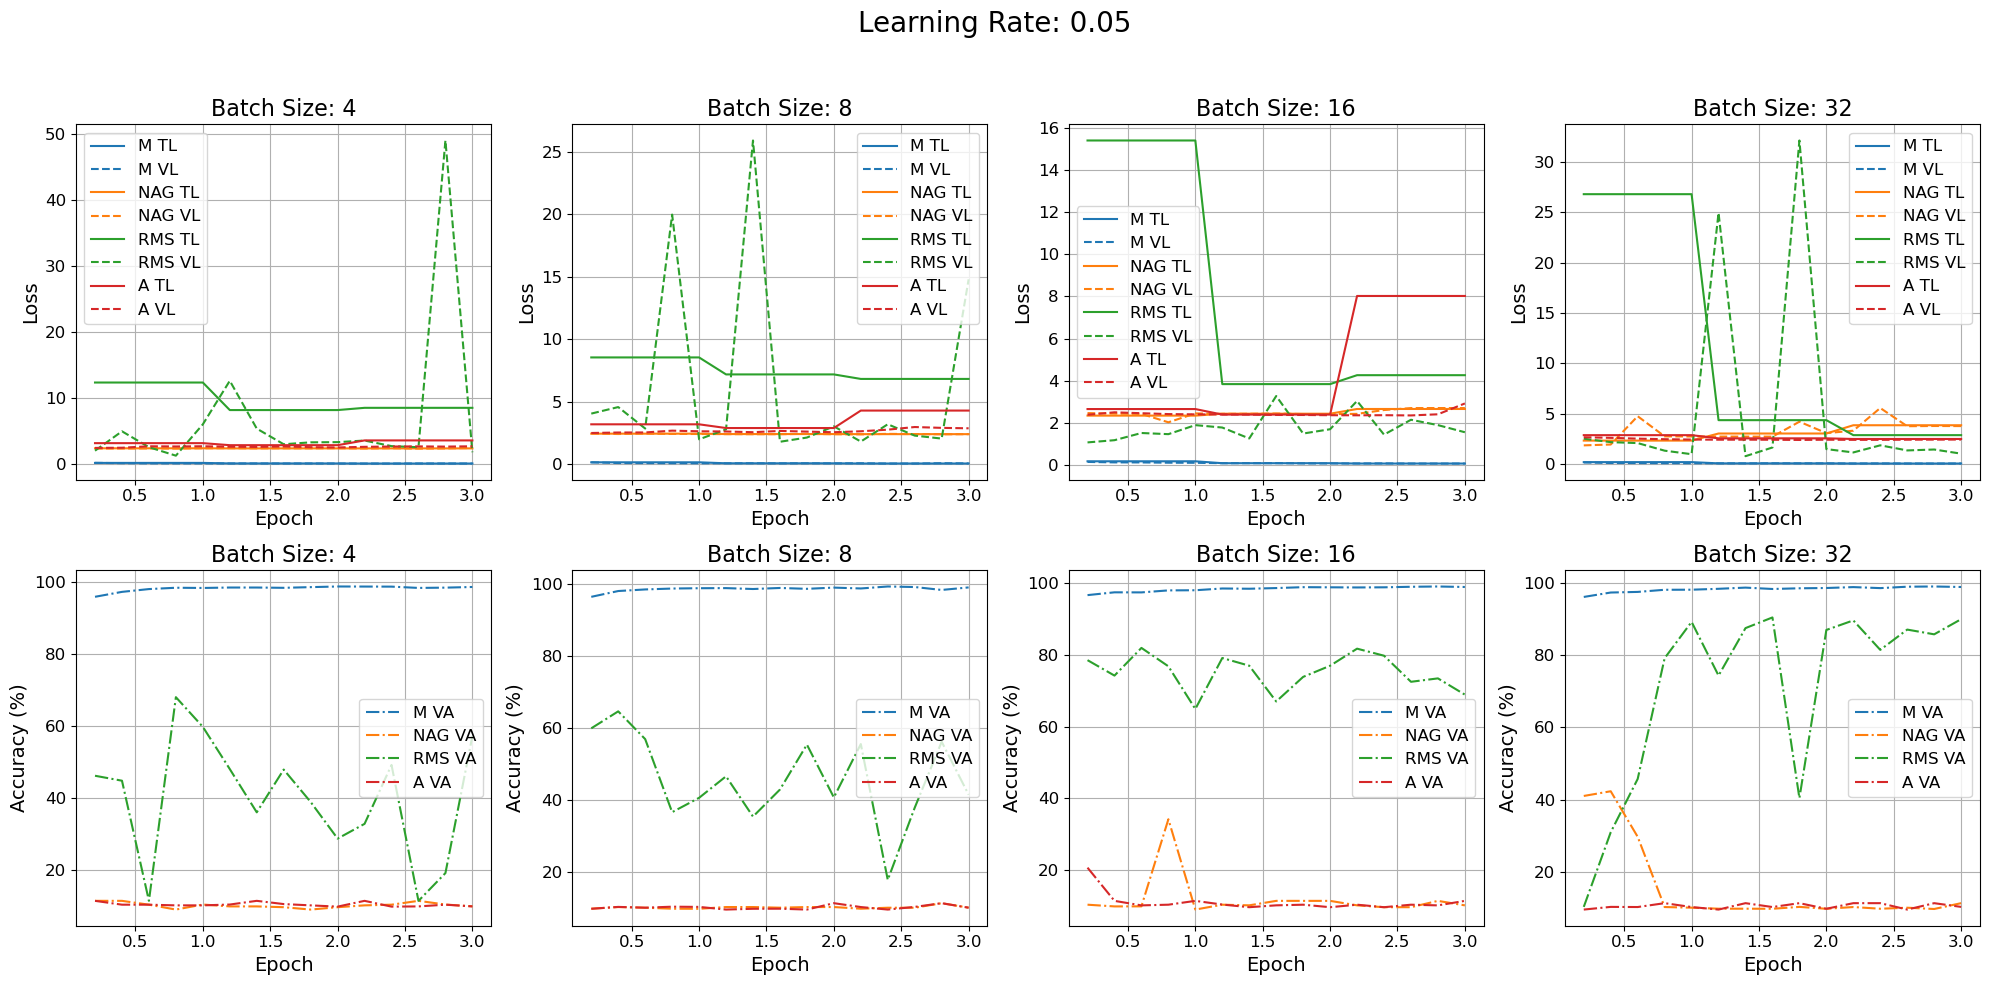

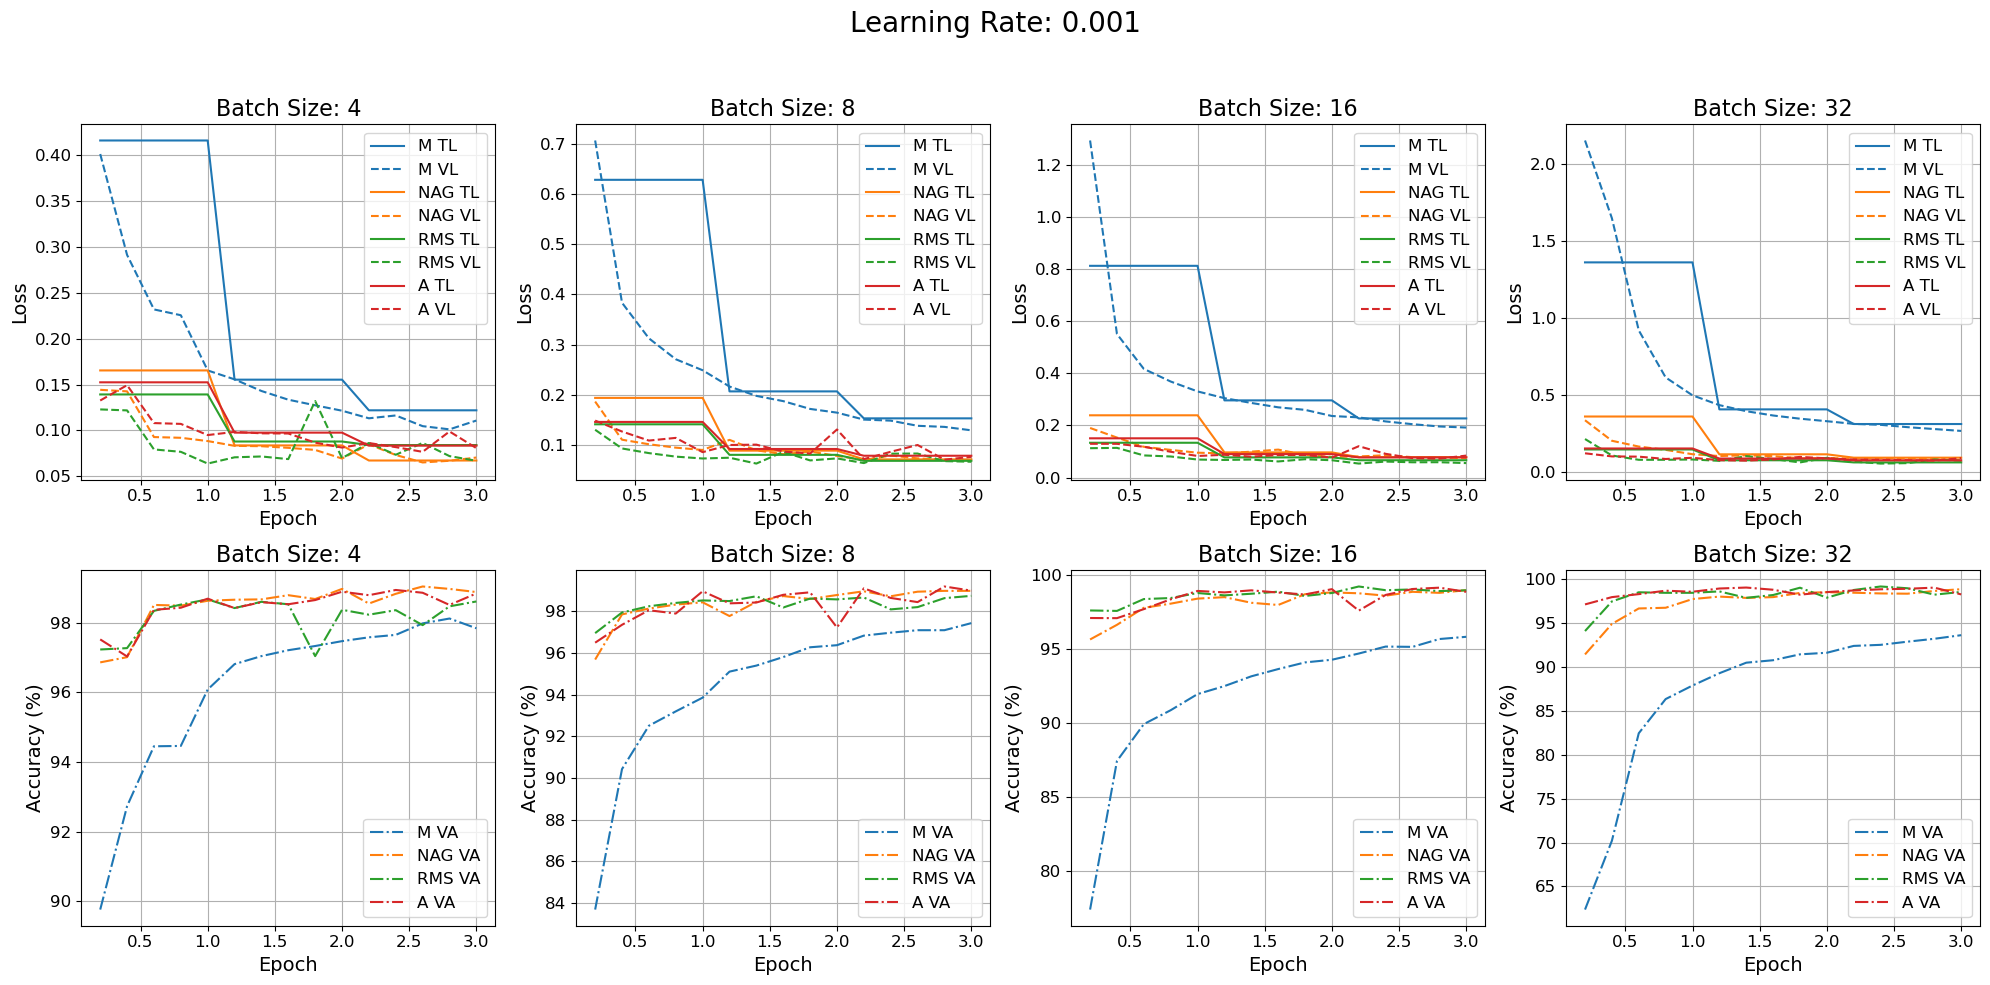

In [60]:
def plot_results(optimizer_results_dict, optimizer_names, batch_sizes, learning_rates, num_epochs):
   
    # Define color map for optimizers
    color_map = plt.get_cmap('tab10')
    colors = {optimizer: color_map(i) for i, optimizer in enumerate(optimizer_names)}
    
    # Define line styles for different metrics
    line_styles = {
        'Train Loss': '-',
        'Val Loss': '--',
        'Val Accuracy': '-.'
    }
    
    # Define initials for optimizers
    optimizer_initials = {
        "Momentum": "M",
        "Nesterov's Accelerated Gradient": "NAG",
        "RMSprop": "RMS",
        "Adam": "A"
    }
    
    # Define initials for metrics
    metric_initials = {
        'Train Loss': 'TL',
        'Val Loss': 'VL',
        'Val Accuracy': 'VA'
    }
    
    for lr in learning_rates:
        fig, axes = plt.subplots(2, len(batch_sizes), figsize=(5 * len(batch_sizes), 10))
        fig.suptitle(f'Learning Rate: {lr}', fontsize=20)
        
        for i, batch_size in enumerate(batch_sizes):
            ax_loss = axes[0, i]  # First row: Loss plots
            ax_acc = axes[1, i]   # Second row: Accuracy plots
            
            for optimizer in optimizer_names:
                try:
                    result = optimizer_results_dict[optimizer][batch_size][lr]
                except KeyError:
                    print(f"Missing data for Optimizer: {optimizer}, Batch Size: {batch_size}, Learning Rate: {lr}")
                    continue
                
                # X-axis: 0.2, 0.4, ..., num_epochs
                x = [0.2 * j for j in range(1, num_epochs * 5 + 1)]  # Assuming validation every 0.2 epochs
                
                # Expand train_loss to match the length of val_loss and val_accuracy
                expanded_train_loss = []
                for epoch_loss in result['train_loss']:
                    expanded_train_loss += [epoch_loss] * 5  # Repeat each epoch loss 5 times
                # Handle any discrepancy in lengths
                if len(expanded_train_loss) < len(x):
                    expanded_train_loss += [result['train_loss'][-1]] * (len(x) - len(expanded_train_loss))
                elif len(expanded_train_loss) > len(x):
                    expanded_train_loss = expanded_train_loss[:len(x)]
                
                color = colors[optimizer]
                
                # Plot Training Loss
                ax_loss.plot(x, expanded_train_loss, linestyle=line_styles['Train Loss'], color=color, label=f'{optimizer_initials[optimizer]} {metric_initials["Train Loss"]}')
                
                # Plot Validation Loss
                ax_loss.plot(x, result['val_loss'], linestyle=line_styles['Val Loss'], color=color, label=f'{optimizer_initials[optimizer]} {metric_initials["Val Loss"]}')
                
                # Plot Validation Accuracy
                ax_acc.plot(x, result['val_accuracy'], linestyle=line_styles['Val Accuracy'], color=color, label=f'{optimizer_initials[optimizer]} {metric_initials["Val Accuracy"]}')
            
            # Configure Loss Plot
            ax_loss.set_title(f'Batch Size: {batch_size}', fontsize=16)
            ax_loss.set_xlabel('Epoch', fontsize=14)
            ax_loss.set_ylabel('Loss', fontsize=14)
            ax_loss.grid(True)
            ax_loss.tick_params(axis='both', which='major', labelsize=12)
            ax_loss.legend(fontsize=12)
            
            # Configure Accuracy Plot
            ax_acc.set_title(f'Batch Size: {batch_size}', fontsize=16)
            ax_acc.set_xlabel('Epoch', fontsize=14)
            ax_acc.set_ylabel('Accuracy (%)', fontsize=14)
            ax_acc.grid(True)
            ax_acc.tick_params(axis='both', which='major', labelsize=12)
            ax_acc.legend(fontsize=12)
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for legends
        plt.show()

# Define Optimizer Results Dictionary
optimizer_results_dict = {
    "Momentum": momentum_results,
    "Nesterov's Accelerated Gradient": nag_results,
    "RMSprop": rmsprop_results,
    "Adam": adam_results
}

# Define Optimizer Names
optimizer_names = ["Momentum", "Nesterov's Accelerated Gradient", "RMSprop", "Adam"]
num_epochs = 3 

# Plot the Results
plot_results(optimizer_results_dict, optimizer_names, batch_sizes, learning_rates, num_epochs)

In [54]:
print("\nFinal Validation Accuracies:")

print("Momentum Optimizer:")
for batch_size in batch_sizes:
    acc = momentum_results[batch_size]['val_accuracy'][-1]
    print(f"Batch Size {batch_size}: {acc:.2f}%")

print("\nNesterov's Accelerated Gradient Optimizer:")
for batch_size in batch_sizes:
    acc = nag_results[batch_size]['val_accuracy'][-1]
    print(f"Batch Size {batch_size}: {acc:.2f}%")

print("\nRMSprop Optimizer:")
for batch_size in batch_sizes:
    acc = rmsprop_results[batch_size]['val_accuracy'][-1]
    print(f"Batch Size {batch_size}: {acc:.2f}%")

print("\nAdam Optimizer:")
for batch_size in batch_sizes:
    acc = adam_results[batch_size]['val_accuracy'][-1]
    print(f"Batch Size {batch_size}: {acc:.2f}%")



Final Validation Accuracies:
Momentum Optimizer:
Batch Size 4, Learning Rate 0.05: 98.74%
Batch Size 4, Learning Rate 0.001: 97.84%
Batch Size 8, Learning Rate 0.05: 98.95%
Batch Size 8, Learning Rate 0.001: 97.44%
Batch Size 16, Learning Rate 0.05: 98.99%
Batch Size 16, Learning Rate 0.001: 95.80%
Batch Size 32, Learning Rate 0.05: 98.79%
Batch Size 32, Learning Rate 0.001: 93.59%

Nesterov's Accelerated Gradient Optimizer:
Batch Size 4, Learning Rate 0.05: 9.82%
Batch Size 4, Learning Rate 0.001: 98.88%
Batch Size 8, Learning Rate 0.05: 10.10%
Batch Size 8, Learning Rate 0.001: 98.99%
Batch Size 16, Learning Rate 0.05: 10.09%
Batch Size 16, Learning Rate 0.001: 98.95%
Batch Size 32, Learning Rate 0.05: 11.35%
Batch Size 32, Learning Rate 0.001: 98.82%

RMSprop Optimizer:
Batch Size 4, Learning Rate 0.05: 57.23%
Batch Size 4, Learning Rate 0.001: 98.61%
Batch Size 8, Learning Rate 0.05: 41.45%
Batch Size 8, Learning Rate 0.001: 98.75%
Batch Size 16, Learning Rate 0.05: 68.93%
Batch S